# SeSiMe
### Sentence/Sequence Similarity Measure

## Goal:  Compare/benchmark different similarity measures for MS-MS spectra
Dataset here: GNPS Dataset of 11134 spectra with smiles.

### Parts:
1. Importing, creating documents
2. Plotting functions
3. For benchmarking: Molecular similarity
4. Spec2Vec
5. For comparison: cosine score
6. For comparison: modified cosine score
7. Explore Cosine and Modified cosine scores
8. Overview/comparison plots

## 1. Importing, creating documents

In [1]:
# Change folder names to fit yours...
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"

# Folder with all the *.ms files:
PATH_MS_DATA = ROOT + "\\Data\\labeled_MS_data\\"

# Folders to store the word2vec model and processed data:
PATH_SAVE_MODEL = ROOT + "\\SeSiMe\\models_trained\\"
PATH_SAVE_DATA = ROOT + "\\SeSiMe\\data\\"

# Folder with cloned SeSiMe repo: https://github.com/florian-huber/SeSiMe
PATH_SESIME = ROOT + "\\SeSiMe\\"

# Folder with nplinker repo (to use a load_spectra function)
PATH_NPLINKER = ROOT + "\\nplinker\\prototype\\"

#mgf_file = PATH_MS_DATA + "GNPSLibraries_allSMILES.mgf"
mgf_file = PATH_MS_DATA + "GNPSLibraries_uniqueSMILES_withFeatureIDs.mgf"

In [2]:
# import general packages
import sys
sys.path.insert(0, PATH_NPLINKER)
sys.path.insert(0, PATH_SESIME)

import helper_functions as functions
import MS_functions

import numpy as np
from metabolomics import load_spectra

## Import spectra and filter peaks
+ Here using an varying intensity threshold that is derived by fitting an exponential to the intensity histogram.
+ Setting exp_intensity_filter to None will switch this off. In that case either no filtering is done (min_intensity_perc = 0), or peaks are removed if their intensit is below min_intensity_perc*max(intensity)
+ The importing functions are still a bit messy...

In [3]:
# Import / Load data
results_file = "filtered_data_unique_smiles_minpeak10_loss500_2dec.json"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0.01, #0
                 exp_intensity_filter = None, #0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], #['mz_', 'mz_'], 
                 sub_spectra = False)

Spectra json file found and loaded.


### Documents

+ Peaks were removed using an exponential fit to the peak intensity distribution. 
+ Words were created using 2 decimals.

### Interesting to note: 
+ Not discriminating between **loss** and **peak** has only very little influence on final result. Test was done with naming all peaks and losses by "mz_....". See load_MGF_data function using parameter: peak_loss_words = ['mz_', 'mz_']

In [4]:
# Have a look at how a document looks like:
print(MS_documents[0])

['peak_74.73', 'peak_79.02', 'peak_89.02', 'peak_89.04', 'peak_90.05', 'peak_95.05', 'peak_98.98', 'peak_105.04', 'peak_107.05', 'peak_117.03', 'peak_118.04', 'peak_134.67', 'peak_135.05', 'peak_135.28', 'peak_136.05', 'peak_137.00', 'peak_137.15', 'peak_145.03', 'peak_147.12', 'peak_160.09', 'peak_161.08', 'peak_162.59', 'peak_163.04', 'peak_163.08', 'peak_163.29', 'peak_164.04', 'peak_165.00', 'peak_165.40', 'peak_166.30', 'peak_167.15', 'peak_168.17', 'peak_172.58', 'peak_175.08', 'peak_181.06', 'peak_229.03', 'peak_237.01', 'peak_330.10', 'peak_330.14', 'loss_92.10', 'loss_100.08', 'loss_148.05', 'loss_154.04', 'loss_156.53', 'loss_160.95', 'loss_161.96', 'loss_162.81', 'loss_163.71', 'loss_164.11', 'loss_165.07', 'loss_165.82', 'loss_166.03', 'loss_166.07', 'loss_166.52', 'loss_168.04', 'loss_169.03', 'loss_182.00', 'loss_184.08', 'loss_191.96', 'loss_192.11', 'loss_193.07', 'loss_193.84', 'loss_194.07', 'loss_194.44', 'loss_211.07', 'loss_212.08', 'loss_222.06', 'loss_224.07', 'l

In [5]:
len(MS_documents)  # number of spectra = number of documents

9550

### Switch to general SeSiMe functionality
Once we have a corpus (e.g. through cells above), we can use SeSiMe to apply different similarity measuring methds. 

In [4]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)

Using TensorFlow backend.


In [5]:
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  67429


### Note
In total it would be about 100.000 words. Many occur only once in the entire corpus and are hence filtered out (makes not sense to place them somewhere in word-space, would be arbitrary!).

Few also are filtered out because they occur too often (in more than 20% of the spectra). Those words have little discriminative power and are hence ignored. Might still be worth keeping them in for comparison!

***
## 2. Plotting functions

In [19]:
import matplotlib
from matplotlib import pyplot as plt

def binned_scatter_plot(bins_x, 
                        bins_y, 
                        H, 
                        edges, 
                        label):
    data_x = []
    data_y = []
    data_z = []
    data_y_mean = []
    for i in range(bins_x):
        for j in range(bins_y):
            data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
            data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
            mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
            data_y_mean.append(mean_mol_score)
            data_z.append(np.sum(H[i,j]))#/np.sum(H[i,:]))
            
    fig, ax = plt.subplots(figsize=(15,10))
    cm = plt.cm.get_cmap('viridis')
    #100*np.array(data_z)**0.5 c=data_y, 
    ax.scatter(data_x, data_y, s=1*np.array(data_z)**0.5, c=data_y, cmap=cm, alpha=0.6)
    plt.plot(data_x, data_y_mean, color='black')
    plt.xlabel("g(s,s') (" + label + ")")
    plt.ylabel("molecular similarity (f(t,t'))")

    # Optionally add a colorbar
    max_color = np.max(data_y)
    min_color = np.min(data_y)
    color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
    cbar.ax.set_yticklabels([x for x in list(color_ticks)])
    plt.ylabel("molecular similarity (f(t,t'))")

In [20]:
def plot_high_sim_fraction(H, edges, label):
    high_low_sim_fraction = []
    for i in range(H.shape[0]):
        low_frac = np.sum(H[i,:12])/np.sum(H[i,:])
        high_frac = np.sum(H[i,12:])/np.sum(H[i,:])
        high_low_sim_fraction.append((low_frac, high_frac))

    fig, ax = plt.subplots(figsize=(6,6))
    _, high_perc = zip(*high_low_sim_fraction)
    high_perc = 100*np.array(high_perc)
    plt.plot(edges[0][:-1], high_perc, color='black')
    plt.xlabel("g(s,s') (" + label + ")")
    plt.ylabel("fraction of highly molecular similarity in % (morgan3 > 0.48)")
    
    return high_perc

In [124]:
def plot_high_sim_percentile(A, B, num_bins = 10000, show_top_percentile = 1.0):
    
    Asort = np.sort(A)
    starting_point = Asort[int(A.shape[0] - A.shape[0]*show_top_percentile/100)]
    if starting_point == 0:
        print("not enough datapoints != 0 above given top-precentile")
        
    low_As = np.where(A < starting_point)[0]
    A_select = np.delete(A, low_As)
    B_select = np.delete(B, low_As)

    length_selected = A_select.shape[0]
    Data = np.zeros((2, length_selected))
    Data[0,:] = A_select
    Data[1,:] = B_select
    Data = Data[:,np.lexsort((Data[1,:], Data[0,:]))]
    
    ref_score = []
    ref_score_cum = []
    
    for i in range(num_bins):
        low = int(i * length_selected/num_bins)
        high = int((i+1) * length_selected/num_bins)
        ref_score.append(np.mean(Data[1,low:high]))
        ref_score_cum.append(np.mean(Data[1,low:]))
    ref_score = np.array(ref_score)
    ref_score_cum = np.array(ref_score_cum)
                         
    fig, ax = plt.subplots(figsize=(6,6))
    #plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_cum, color='black')
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum, color='black')
    plt.xlabel("Top percentile of spectral similarity score g(s,s')")
    plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
    #plt.xlim(show_top_percentile, 0)
    
    fig, ax = plt.subplots(figsize=(6,6))
    #plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_cum, color='black')
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score, color='black')
    plt.xlabel("Top percentile of spectral similarity score g(s,s')")
    plt.ylabel("Mean molecular similarity (f(t,t') at that percentile)")
    #plt.xlim(show_top_percentile, 0)
    
    return ref_score, ref_score_cum

In [34]:
def plot_high_sim_percentile_old(A, B, num_bins = 10000, show_top_percentile = 1.0):
    
    top_bin_cutoff = int(num_bins*show_top_percentile/100) 
    hist, bin_edges = np.histogram(A, histedges_equalN(A, num_bins))
    
    ref_score = []
    ref_score_cum = []
    for i in range(top_bin_cutoff):    
        ref_score.append(np.mean(B[np.where((A > bin_edges[-(i+2)]) & (A < bin_edges[-(i+1)]))]))
        ref_score_cum.append(np.mean(B[np.where((A > bin_edges[-(i+2)]))]))
    ref_score = np.array(ref_score)
    ref_score_cum = np.array(ref_score_cum)
                         
    fig, ax = plt.subplots(figsize=(6,6))
    #plt.plot((1/100*(1+np.arange(top_bin_cutoff))), ref_score_cum, color='black')
    #plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_cum, color='black')
    plt.plot((100/num_bins*np.arange(top_bin_cutoff)), ref_score_cum, color='black')
    plt.xlabel("Top percentile of spectral similarity score g(s,s')")
    plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
    plt.xlim(show_top_percentile, 0)
    
    fig, ax = plt.subplots(figsize=(6,6))
    #plt.plot((1/100*(1+np.arange(top_bin_cutoff))), ref_score, color='black')
    #plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_cum, color='black')
    plt.plot((100/num_bins*np.arange(top_bin_cutoff)), ref_score_cum, color='black')
    plt.xlabel("Top percentile of spectral similarity score g(s,s')")
    plt.ylabel("Mean molecular similarity (f(t,t') at that percentile)")
    plt.xlim(show_top_percentile, 0)
    
    return ref_score, ref_score_cum

def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

***
## 3. For benchmarking: molecular similarity
Benchmarking - Reference score is molecular similarity (based on mol. fingerprints)

### Calculate/load molecular similarity scores
+ first calculate molecular fingerprints
+ then calculate (or load if file exists) molecular similarity scores.  

Method for calculating fingerprints here can be "morgan1", "morgan2", "morgan3" or "daylight". For morgan fingerprints scores will be based on Dice scores. For "daylight" fingerprint it will be Tanimoto scores. 

In [6]:
from MS_functions import get_mol_fingerprints
molecules, fingerprints_m3, exclude_IDs = get_mol_fingerprints(spectra_dict, method = "morgan3")
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]

Problem with molecule 7402
Could not be solved by using the InChikey.
Problem with molecule 7452
Could not be solved by using the InChikey.
Problem with molecule 7522
Could not be solved by using the InChikey.
Problem with molecule 7612
Could not be solved by using the InChikey.
Problem with molecule 13527
Could not be solved by using the InChikey.
Problem with molecule 13771
Could not be solved by using the InChikey.
Problem with molecule 14111
Could not be solved by using the InChikey.
Problem with molecule 14429
Could not be solved by using the InChikey.
Problem with molecule 14652
Could not be solved by using the InChikey.
Problem with molecule 15085
Could not be solved by using the InChikey.
Problem with molecule 15140
Could not be solved by using the InChikey.
Problem with molecule 15175
Could not be solved by using the InChikey.
Problem with molecule 15531
Could not be solved by using the InChikey.
Problem with molecule 15810
Could not be solved by using the InChikey.
Problem wi

### Get molecular similarity matrix (based on molecular fingerprints).  
Here used: Tanimoto scores for daylight fingerprints. And dice score for morgan-3 fingerprints.

In [16]:
filename = PATH_SAVE_DATA + "tanimoto_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_morgan3.npy"
M_sim_morgan3 = MS_functions.tanimoto_matrix(spectra, 
                                                      fingerprints_m3,
                                                      filename = filename)

Molecular similarity scores found and loaded.


#### Baseline: Histogram of all Tanimoto/Dice scores

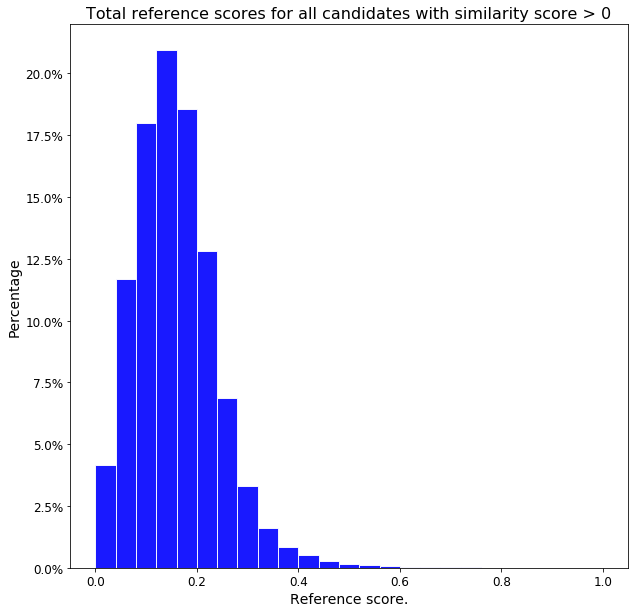

In [17]:
n, bins = MS_functions.similarity_histogram(tanimoto_similarities, tanimoto_similarities, 0, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_baseline.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

--> Based on this plot we can argue that we set the threshold between low- and high-molecular-similarity at **Dice(morgan3) = 0.5**.

***
## 4. Spec2Vec
### 4.1 Model trained on dataset itself (unique smiles)

In [8]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_gnps_uniquesmiles_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [9]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents.5560  of  9550  documents. 5700  of  9550  documents. 6170  of  9550  documents.6480  of  9550  documents.

### Get all-vs-all matrix of similarity scores

In [10]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [13]:
remove_diagonal = []
length = M_sim_ctr.shape[0]
for i in range(length):
    remove_diagonal.append(i*length + i)

remove_diagonal = np.array(remove_diagonal)    

In [135]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr.reshape(9550**2), remove_diagonal)
B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

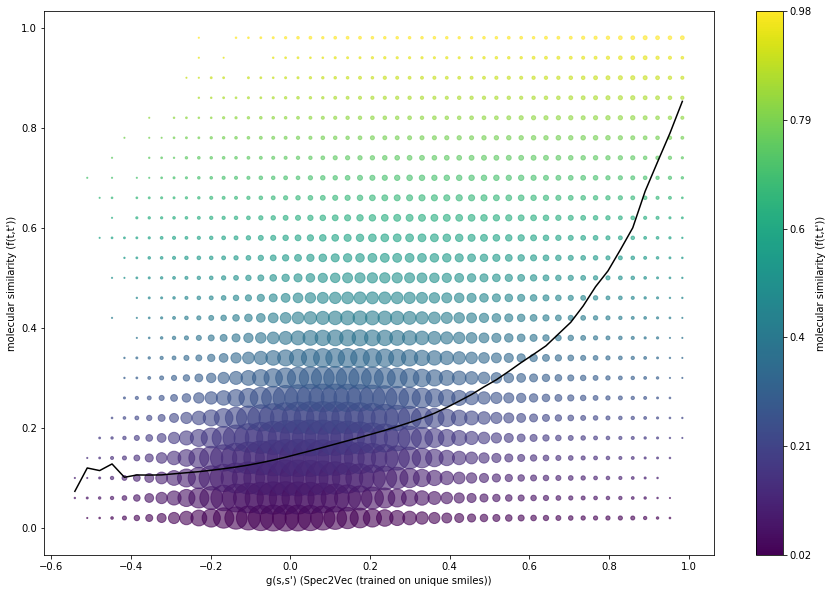

In [114]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (trained on unique smiles)")

Set similarity threshold to:  0.8505918971390208


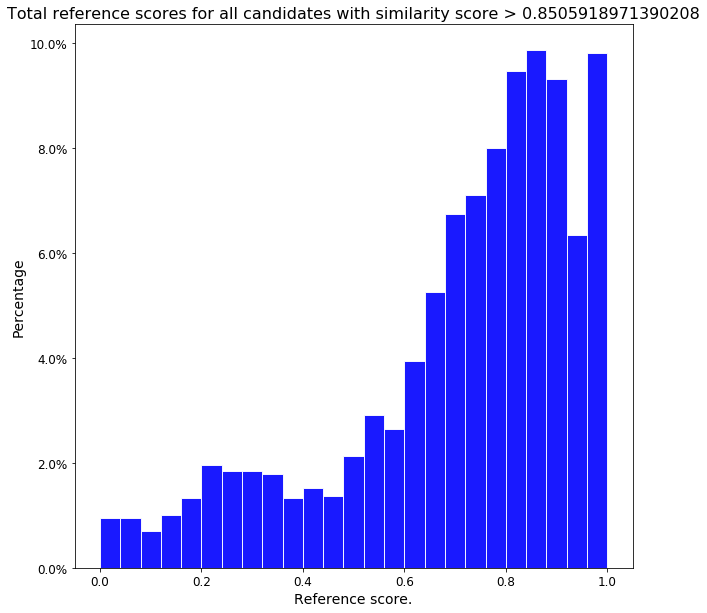

Percentage of highly similar molecules within selection:  83.4 %


In [22]:
num_best = 10000  # arbitrary number, but at least same for all methods...
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, M_sim_morgan3, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### Potential issue: The choice of selection the 10.000 best similarity pairs is of course arbitrary. 
Maybe we can use another plot like the next instead?

### Better in my opinion would be something like this:

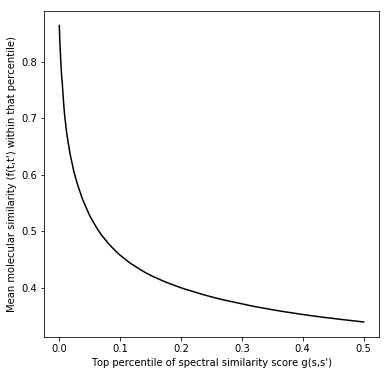

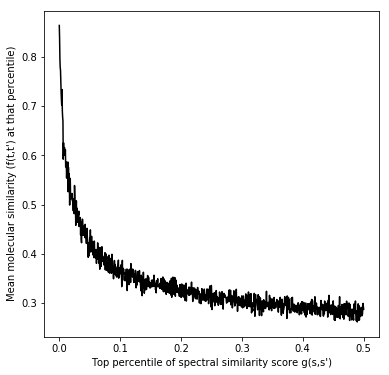

In [136]:
ref_score_w2v, ref_score_w2v_cum = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

***
## 5. For comparison: cosine score

### 5.1 Cosine score based on gnps default 1 (tol = 0.5, min_match = 6)

### Calculate/load cosine scores 
+ Calculating is a bit faster than the modified cosine score, but can still become **slow**, especially when using small tolerances and little filtering (resulting in many peaks...). 
+ I made a faster function but that is based on another way of binning making it less comparable...

In [137]:
filename = PATH_SAVE_DATA + "Cosine_gnps_uniquesmiles_tol05_minmatch6.npy"
M_sim_cosine = MS_functions.cosine_matrix(spectra, 
                                          tol = 0.5, 
                                          max_mz = 1000, 
                                          min_mz = 0, 
                                          min_match = 6, 
                                          min_intens = 0,
                                          filename = filename,
                                          num_workers = 4)

Complete cosine similarity scores found and loaded.


In [138]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_cosine.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

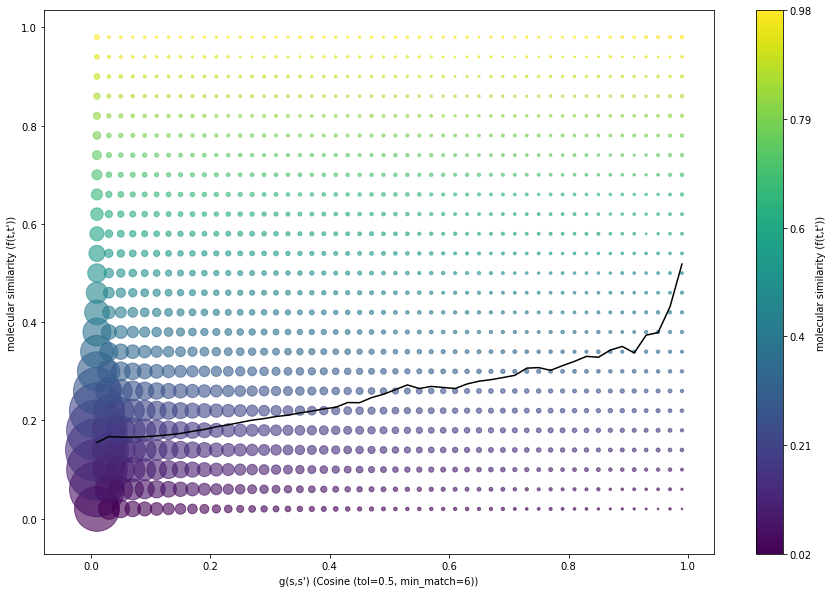

In [160]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Cosine (tol=0.5, min_match=6)")

Set similarity threshold to:  0.8505918971390208


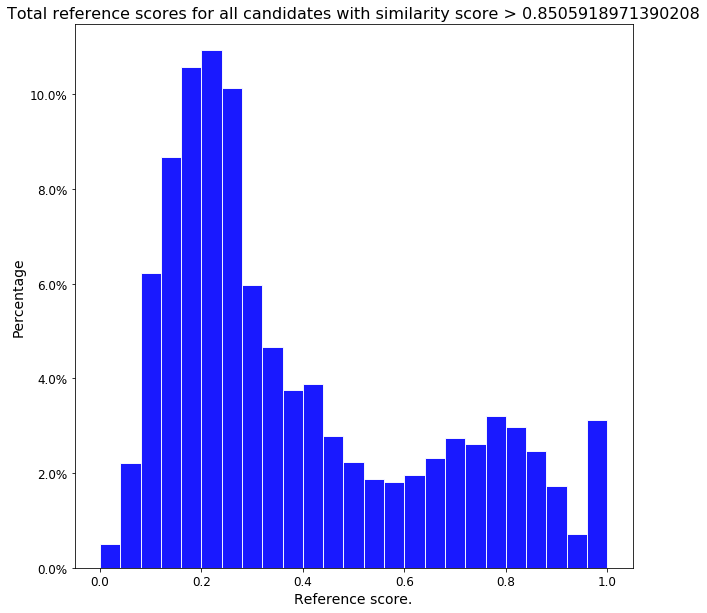

Percentage of highly similar molecules within selection:  29.7 %


In [26]:
num_best = 10000  # arbitrary number, but at least same for all methods...
threshold = np.sort(M_sim_ctr.reshape(M_sim_cosine.shape[0]**2))[-(num_best + M_sim_cosine.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_cosine, M_sim_morgan3, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_cosine_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

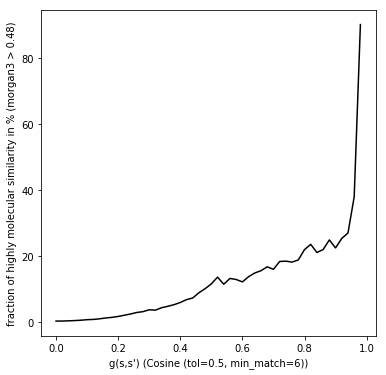

In [93]:
label = "Cosine (tol=0.5, min_match=6)"
high_perc_cosine1 = plot_high_sim_fraction(H, edges, label)

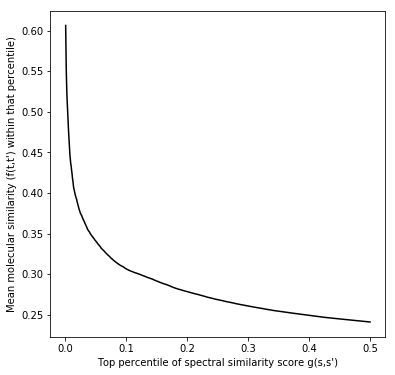

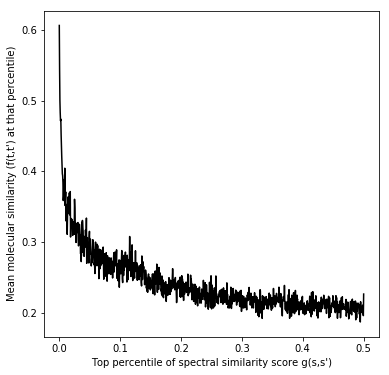

In [139]:
ref_score_cosine, ref_score_cosine_cum = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

### 5.2 Cosine score based on gnps default 2 (tol = 0.02, min_match = 6)

In [140]:
filename = PATH_SAVE_DATA + "Cosine_gnps_uniquesmiles_tol002_minmatch6.npy"
M_sim_cosine2 = MS_functions.cosine_matrix(spectra, 
                                          tol = 0.02, 
                                          max_mz = 1000, 
                                          min_mz = 0, 
                                          min_match = 6, 
                                          min_intens = 0,
                                          filename = filename,
                                          num_workers = 4)

Complete cosine similarity scores found and loaded.


In [141]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_cosine2.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

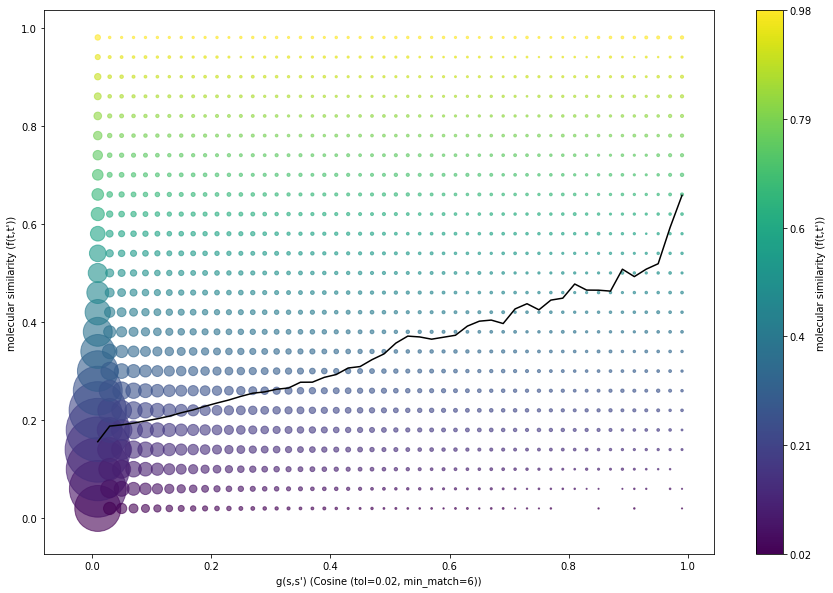

In [227]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Cosine (tol=0.02, min_match=6)")

Set similarity threshold to:  0.8505918971390208


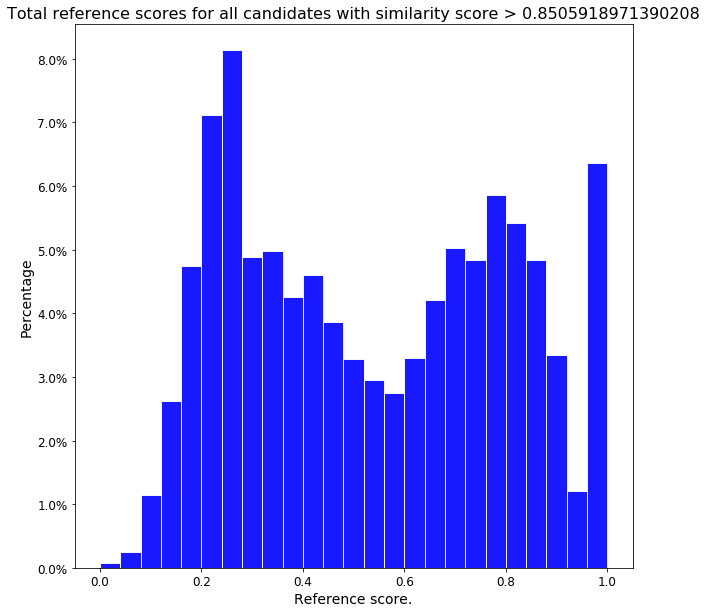

Percentage of highly similar molecules within selection:  53.36 %


In [228]:
num_best = 10000  # arbitrary number, but at least same for all methods...
threshold = np.sort(M_sim_ctr.reshape(M_sim_cosine2.shape[0]**2))[-(num_best + M_sim_cosine2.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_cosine2, M_sim_morgan3, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_cosine_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

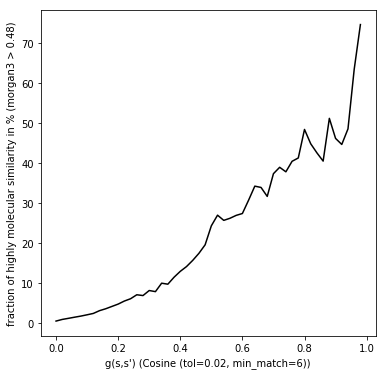

In [229]:
label = "Cosine (tol=0.02, min_match=6)"
high_perc_cosine2 = plot_high_sim_fraction(H, edges, label)

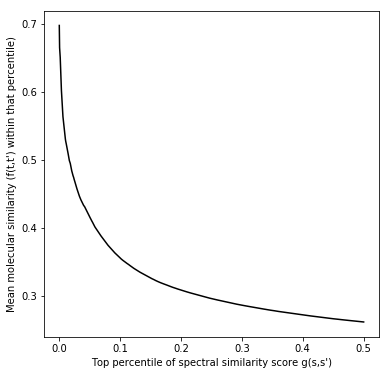

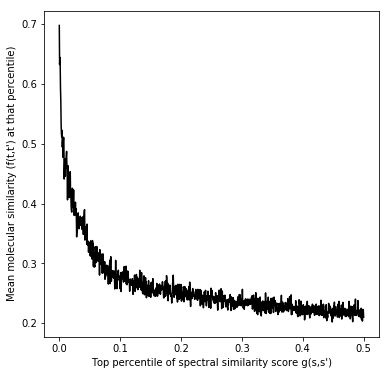

In [142]:
ref_score_cosine2, ref_score_cosine_cum2 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

### 5.3 Cosine score with comparible accuracy (tol = 0.005, min_match = 1)

In [150]:
filename = PATH_SAVE_DATA + "Cosine_gnps_uniquesmiles_tol0005_minmatch1.npy"
M_sim_cosine3 = MS_functions.cosine_matrix(spectra, 
                                          tol = 0.005, 
                                          max_mz = 1000, 
                                          min_mz = 0, 
                                          min_match = 1, 
                                          min_intens = 0,
                                          filename = filename,
                                          num_workers = 4)

Complete cosine similarity scores found and loaded.


In [151]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_cosine3.reshape(9550**2), remove_diagonal)
B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

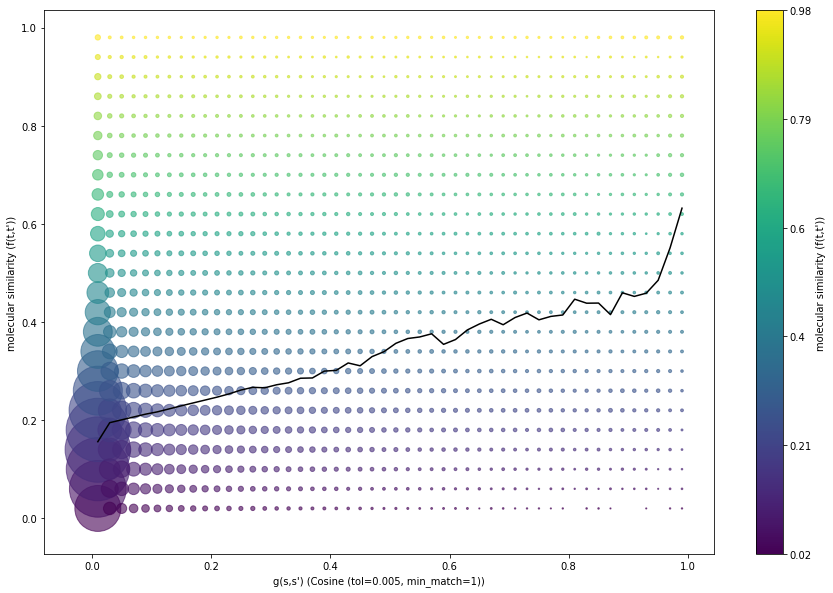

In [22]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Cosine (tol=0.005, min_match=1)")

Set similarity threshold to:  0.8505918971390208


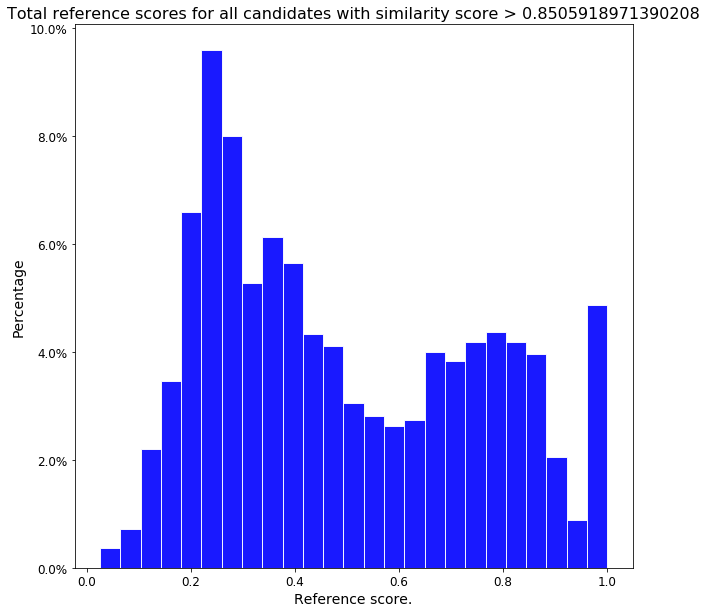

Percentage of highly similar molecules within selection:  43.57 %


In [23]:
num_best = 10000  # arbitrary number, but at least same for all methods...
threshold = np.sort(M_sim_ctr.reshape(M_sim_cosine3.shape[0]**2))[-(num_best + M_sim_cosine3.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_cosine3, M_sim_morgan3, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_cosine_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

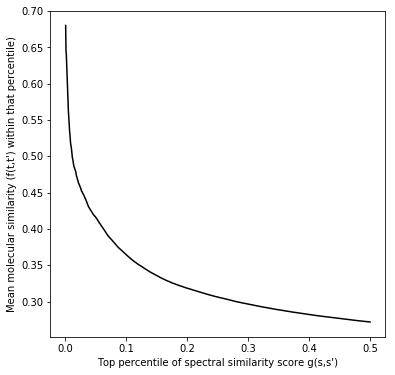

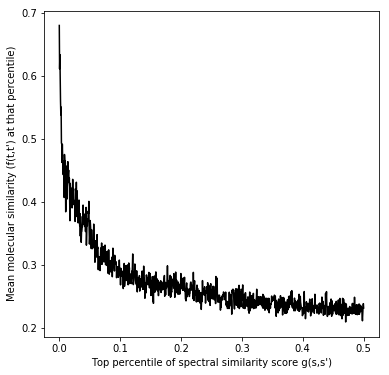

In [152]:
ref_score_cosine3, ref_score_cosine_cum3 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

### 5.4 Cosine score with comparible accuracy (tol = 0.005, min_match = 6)

In [146]:
filename = PATH_SAVE_DATA + "Cosine_gnps_uniquesmiles_tol0005_minmatch6.npy"
M_sim_cosine4 = MS_functions.cosine_matrix(spectra, 
                                          tol = 0.005, 
                                          max_mz = 1000, 
                                          min_mz = 0, 
                                          min_match = 6, 
                                          min_intens = 0,
                                          filename = filename,
                                          num_workers = 4)

Complete cosine similarity scores found and loaded.


In [147]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_cosine4.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

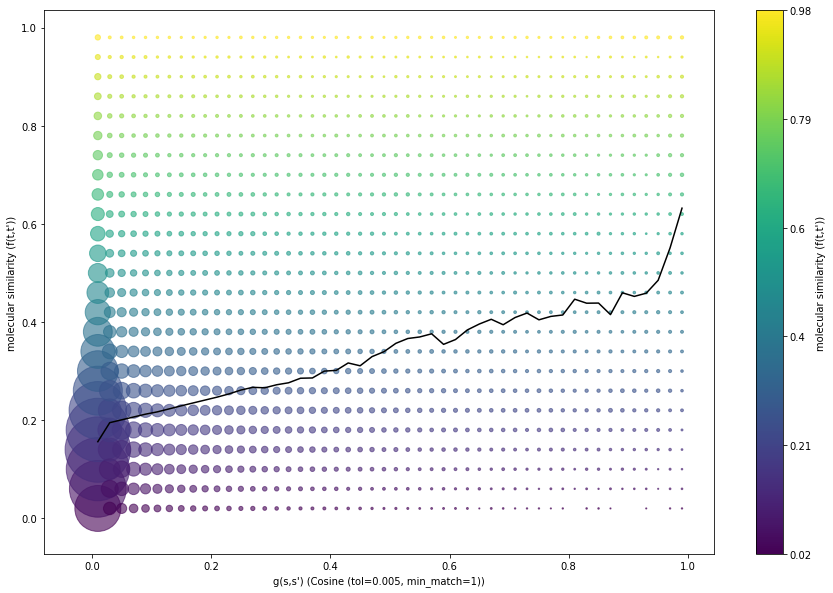

In [22]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Cosine (tol=0.005, min_match=6)")

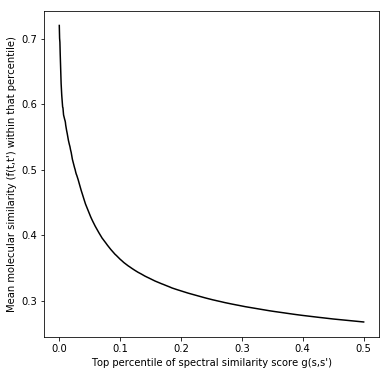

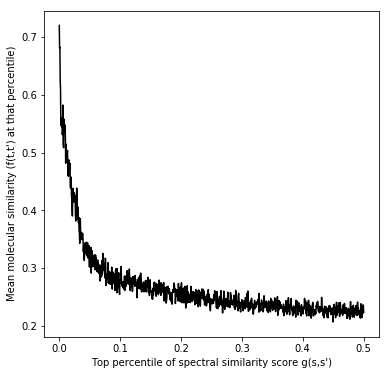

In [149]:
ref_score_cosine4, ref_score_cosine_cum4 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

***
## 6. For comparison: modified cosine score

### 6.1 Mod. Cosine score based on gnps default 1 (high tol)

### Calculate/load modified cosine score (here using "fast" way)
+ Be aware: calculating those is **very slow** !
+ Function below will load the given file and only calculate the scores from scratch if no such file is found.
+ Method choices are 'fast' or 'hungarian', the latter being more exact but even slower.

In [13]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_dec2_tol05_minmatch6_fast.npy"
M_sim_molnet = MS_functions.molnet_matrix(spectra, 
              tol = 0.5, 
              max_mz = 1000, 
              min_mz = 0, 
              min_match = 6, 
              min_intens = 0.01,
              filename = filename,
              method = 'fast',
              num_workers = 8,
              safety_points = 50)

Uncomplete MolNet similarity scores found and loaded.
Missing MolNet scores will be calculated.
About  93.9340610180642 % of the values already completed.
Calculate pairwise MolNet scores by  8 number of workers.


C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\SeSiMe\MS_functions.py:1559: RuntimeWarning: overflow encountered in long_scalars
  print('\r', ' Calculated MolNet for pair ', i, '--', j, '. ( ', np.round(200*(counter+1)/len_spectra**2, 2), ' % done).', end="")


  Calculated MolNet for pair  9480 -- 9508 . (  5.81  % done).. (  5.75  % done)..68  % done).60 -- 7476 . (  5.54  % done).  % done). % done). -- 3326 . (  0.02  % done). 725 -- 6513 . (  0.07  % done). 725 -- 9513 . (  0.07  % done).-- 3778 . (  0.17  % done). 0.18  % done).. (  0.22  % done).. (  0.24  % done). 6953 . (  0.33  % done). 1092 -- 8495 . (  0.35  % done). % done).0.42  % done).0.46  % done). 0.49  % done). 0.52  % done).1162 -- 4943 . (  0.55  % done). . (  0.74  % done).6377 . (  0.75  % done). 8111 . (  0.77  % done).. (  0.78  % done). Calculated MolNet for pair  1345 -- 1957 . (  0.85  % done).1345 -- 4957 . (  0.86  % done).0.86  % done).. (  0.98  % done).1.03  % done).3996 . (  1.07  % done). 1.09  % done).1470 --  1.14  % done).1.16  % done). % done).1594 -- 4642 . (  1.37  % done). Calculated MolNet for pair  1594 -- 8642 . (  1.38  % done).7710 . (  1.39  % done). . (  1.4  % done).. (  1.45  % done).. (  1.47  % done).-- 5143 . (  1.47  % done).1.52  % done).

In [153]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_dec2_tol05_minmatch6_fast.npy"
M_sim_molnet = np.load(filename)

In [154]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_molnet.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

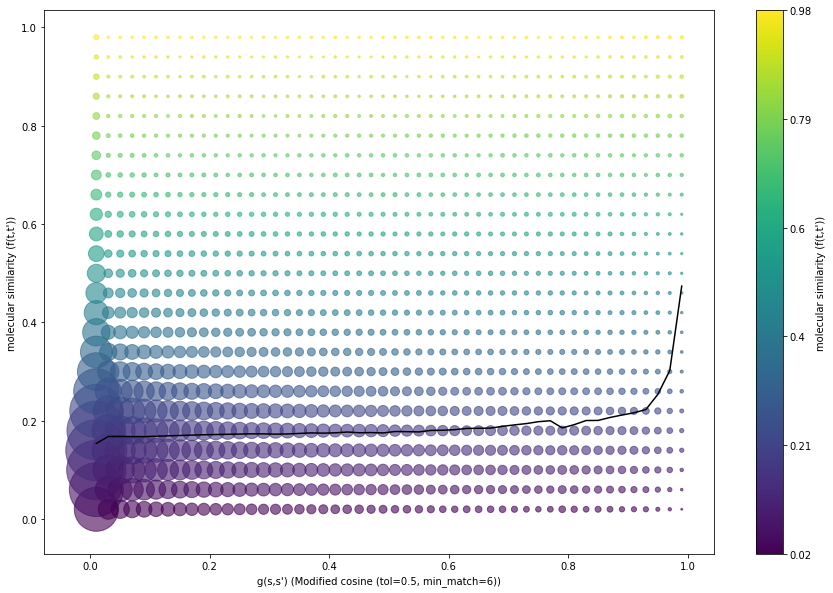

In [232]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Modified cosine (tol=0.5, min_match=6)")

Set similarity threshold to:  0.9590343842767778


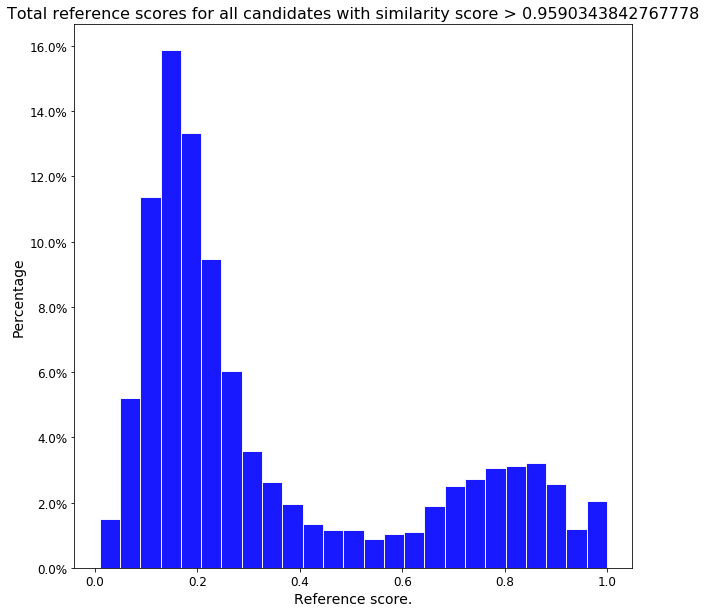

Percentage of highly similar molecules within selection:  26.55 %


In [30]:
num_best = 10000  # arbitrary number, but at least same for all methods...
threshold = np.sort(M_sim_molnet.reshape(M_sim_molnet.shape[0]**2))[-(num_best + M_sim_molnet.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_molnet, M_sim_morgan3, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_molnet_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

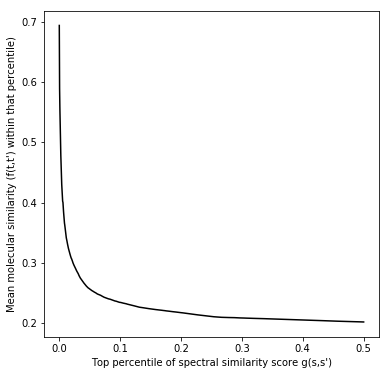

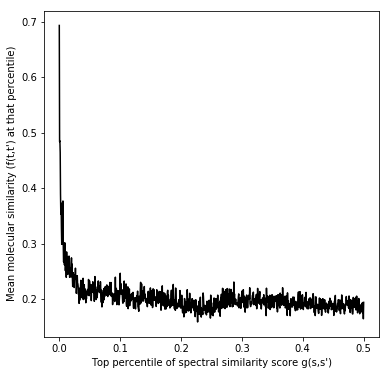

In [155]:
ref_score_molnet1, ref_score_molnet1_cum = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

### 6.2 Mod. Cosine score based on gnps default 2 (low tol)

In [156]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_dec2_tol002_minmatch6_fast.npy"
"""M_sim_molnet2 = MS_functions.molnet_matrix(spectra, 
                  tol = 0.02, 
                  max_mz = 1000, 
                  min_mz = 0, 
                  min_match = 6, 
                  min_intens = 0.01,
                  filename = filename,
                  method = 'fast',
                  num_workers = 8,
                  safety_points = 50)
"""

# or loading without checks:
M_sim_molnet2 = np.load(filename)

In [157]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_molnet2.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

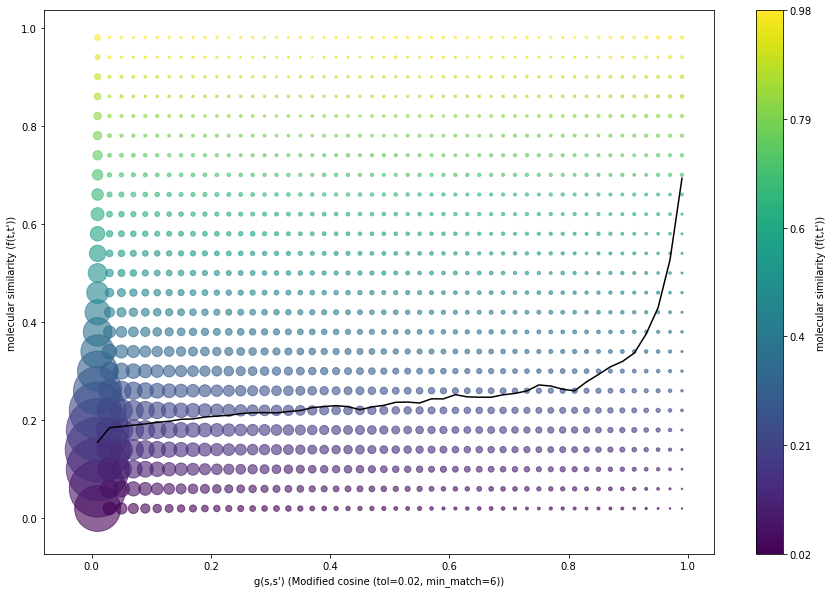

In [236]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Modified cosine (tol=0.02, min_match=6)")

Set similarity threshold to:  0.919214998587065


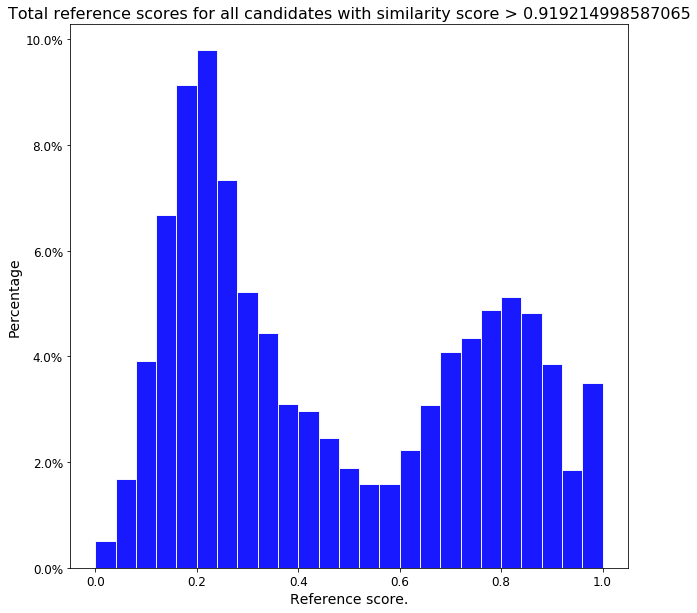

Percentage of highly similar molecules within selection:  42.78 %


In [35]:
num_best = 10000  # arbitrary number, but at least same for all methods...
threshold = np.sort(M_sim_molnet2.reshape(M_sim_molnet2.shape[0]**2))[-(num_best + M_sim_molnet2.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_molnet2, M_sim_morgan3, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_molnet_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

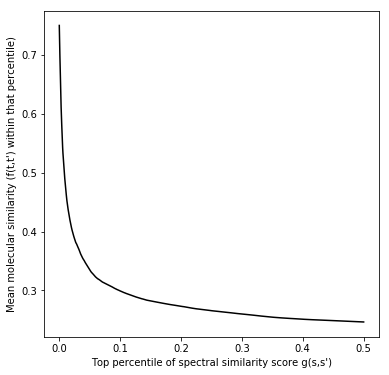

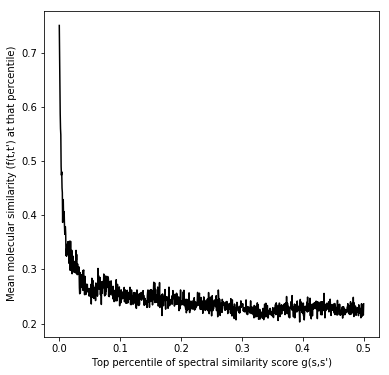

In [158]:
ref_score_molnet2, ref_score_molnet2_cum = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

### 6.3 Mod. Cosine score usinc comparable accuracy (tol = 0.005)

In [32]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_dec2_tol05_fast.npy"
M_sim_molnet3, M_sim_molnet3_matches = MS_functions.molnet_matrix(spectra, 
                  tol= 0.005, 
                  max_mz= 1000, 
                  min_mz = 0, 
                  min_intens = 0.01,
                  filename = filename,
                  method='fast',
                  num_workers = 4,
                  safety_points = 50)

In [28]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_dec2_tol05_fast.npy"
M_sim_molnet3 = np.load(filename)
M_sim_molnet3_matches = np.load(filename[:-4]+ "_matches.npy")

In [29]:
M_sim_molnet3_minmatch6 = M_sim_molnet3 * (M_sim_molnet3_matches > 5)

In [30]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_molnet3_minmatch6.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

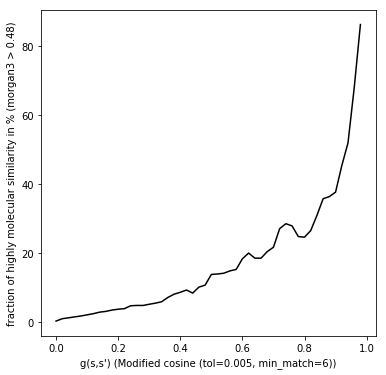

In [31]:
label = "Modified cosine (tol=0.005, min_match=6)"
high_perc_molnet3_minmatch6 = plot_high_sim_fraction(H, edges, label)

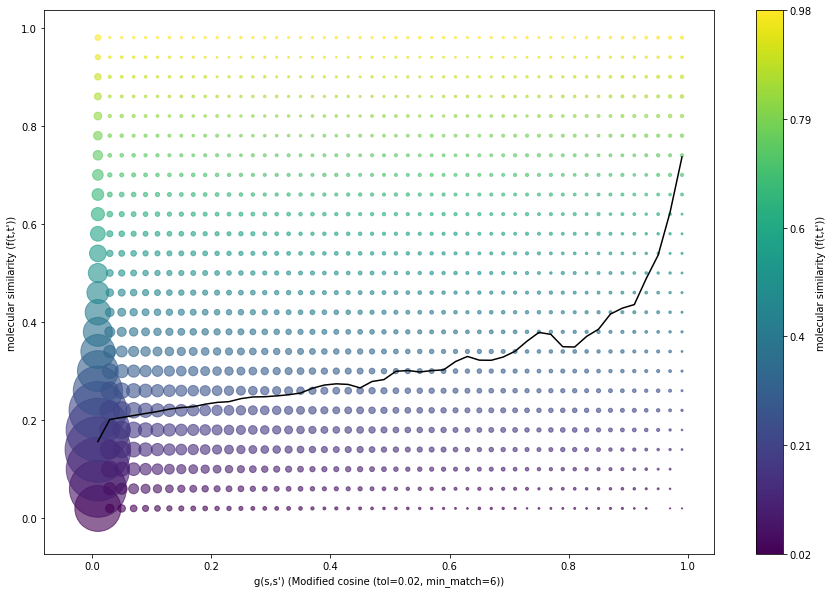

In [32]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Modified cosine (tol=0.02, min_match=6)")

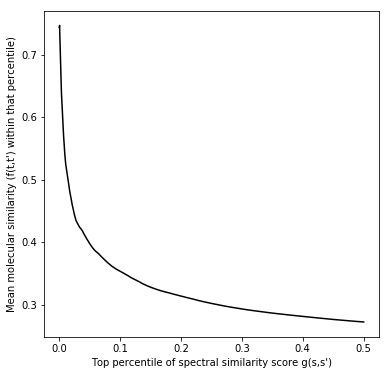

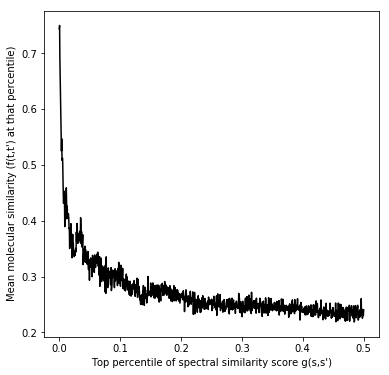

In [125]:
ref_score_molnet3_minmatch6, ref_score_molnet3_minmatch6_cum = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

***
## 7. Explore Cosine and Modified cosine scores (e.g. find optimum)
### 7.1. Explore the influcence of min_match on MolNet score performance:

In [317]:
bins_x = 50
bins_y = 25
num_bins = 1000
show_top_percentile = 0.5

ref_score_cum_collection = []

N = 19
for i in range(N):
    print("Round", i, "of", N)
    M_sim_molnet3_test = M_sim_molnet3 * (M_sim_molnet3_matches > i)

    A = np.delete(M_sim_molnet3_test.reshape(9550**2), remove_diagonal)
    H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))
    
    # Calculate cumulative distributions
    Asort = np.sort(A)
    starting_point = Asort[int(A.shape[0] - A.shape[0]*show_top_percentile/100)]
    if starting_point == 0:
        print("not enough datapoints != 0 above given top-precentile")
        
    low_As = np.where(A < starting_point)[0]
    A_select = np.delete(A, low_As)
    B_select = np.delete(B, low_As)

    length_selected = A_select.shape[0]
    Data = np.zeros((2, length_selected))
    Data[0,:] = A_select
    Data[1,:] = B_select
    Data = Data[:,np.lexsort((Data[1,:], Data[0,:]))]

    ref_score_cum = []
    
    for i in range(num_bins):
        low = int(i * length_selected/num_bins)
        high = int((i+1) * length_selected/num_bins)
        ref_score_cum.append(np.mean(Data[1,low:]))

    ref_score_cum_collection.append(np.array(ref_score_cum))

Round 0 of 19
Round 1 of 19


MemoryError: 

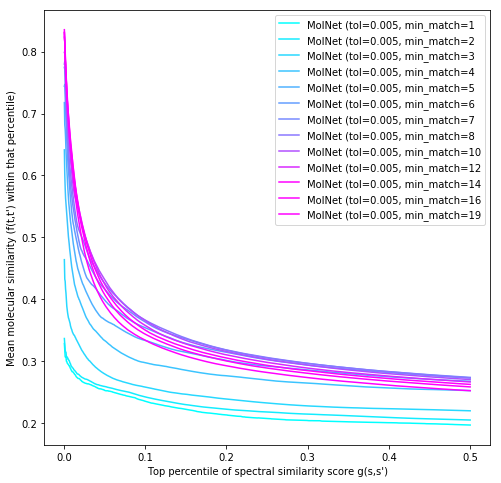

In [176]:
# Compare all:
fig, ax = plt.subplots(figsize=(8,8))
#plot_colors = ['darkcyan', 'purple', 'seagreen', 'steelblue', 'darkcyan', 'firebrick', 'darkcyan', 'purple', 'seagreen', 'steelblue', 'darkcyan', 'firebrick']
#color_sequence = ['#003f5c','#882556', '#D65113', '#ffa600', '#58508d', '#bc5090', '#2651d1', '#2f4b7c', '#ff6361', '#a05195', '#d45087']
cmap = matplotlib.cm.get_cmap('cool') #('plasma') #('Spectral')

selection = [0,1,2,3,4,5,6,7,9,11,13,15,18]
N = len(selection)
for i, select in selection:
#for i, ref_score_cum in enumerate(ref_score_cum_collection[:-2]):
    ref_score_cum = ref_score_cum_collection[select]
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum, 
             color=cmap(i/N), #color_sequence[i], 
             label="MolNet (tol=0.005, min_match="+str(select+1))

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.savefig('molnet_min_match_comparison.pdf')

In [288]:
ignored_pairs = []

for i in range(20):
    A = np.delete(M_sim_molnet3_matches.reshape(9550**2), remove_diagonal)
    ignored_pairs.append(np.sum(A < i+1))

In [293]:
((9550**2 - 9550)/2)

45596475.0

In [296]:
[np.round(100*(x/(9550**2 - 9550)),4) for x in ignored_pairs]

[56.5041,
 76.8162,
 87.4909,
 92.167,
 94.4652,
 95.8234,
 96.7193,
 97.3519,
 97.8164,
 98.1688,
 98.4474,
 98.6686,
 98.8495,
 98.9974,
 99.1214,
 99.2266,
 99.3169,
 99.3944,
 99.4603,
 99.5184]

In [311]:
100*(np.sum(M_sim_morgan3 > 0.3)/(9550**2 - 9550))

4.988004006888691

### Alternative measure: correlation coefficients between molecular similarity and spectral similarity

In [297]:
def corr_coeffs(matA, matB, A_cutoff):
    A = matA.reshape(matA.shape[0]*matA.shape[1])
    idx = np.where(A >= A_cutoff)[0]
    B = matB.reshape(matB.shape[0]*matB.shape[1])
    
    print(np.corrcoef(A[idx],B[idx]))

In [299]:
corr_coeffs(M_sim_morgan3, (M_sim_molnet3*(M_sim_molnet3_matches > 0)), A_cutoff=0)

[[1.         0.07352127]
 [0.07352127 1.        ]]


In [301]:
corr_coeffs(M_sim_morgan3, (M_sim_molnet3*(M_sim_molnet3_matches > 5)), A_cutoff=0)

[[1.         0.15743206]
 [0.15743206 1.        ]]


In [303]:
corr_coeffs(M_sim_morgan3, M_sim_ctr, A_cutoff=0)

[[1.         0.36200996]
 [0.36200996 1.        ]]


In [307]:
corr_coeffs(M_sim_morgan3, (M_sim_molnet3*(M_sim_molnet3_matches > 5)), A_cutoff=0.7)

[[1.         0.55803825]
 [0.55803825 1.        ]]


In [304]:
corr_coeffs(M_sim_morgan3, M_sim_ctr, A_cutoff=0.7)

[[1.         0.56015331]
 [0.56015331 1.        ]]


In [305]:
corr_coeffs(M_sim_ctr, M_sim_morgan3, A_cutoff=0.7)

[[1.         0.63660892]
 [0.63660892 1.        ]]


## Explore the influcence of min_match on Cosine score performance:

In [192]:
filename = PATH_SAVE_DATA + "Cosine_gnps_uniquesmiles_dec2_tol0005_min_intens0002_fast.npy"
M_sim_cosine0005, M_sim_cosine0005_matches = MS_functions.cosine_matrix(spectra, 
                  tol= 0.005, 
                  max_mz= 1000, 
                  min_mz = 0, 
                  min_intens = 0.002,
                  filename = filename,
                  num_workers = 4)

Complete cosine similarity scores found and loaded.


ValueError: too many values to unpack (expected 2)

In [193]:
M_sim_cosine0005 = np.load(filename)
M_sim_cosine0005_matches = np.load(filename[:-4]+ "_matches.npy")

In [200]:
M_sim_cosine0005_matches[0,:20], M_sim_molnet3_matches[0,:20]

(array([38.,  3.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  3.,  1.,  2.,
         0.,  3.,  0.,  5.,  9.,  0.,  0.]),
 array([15.,  2.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  3.,  1.,  2.,
         0.,  3.,  0.,  4.,  5.,  0.,  0.]))

In [194]:
bins_x = 50
bins_y = 25
num_bins = 1000
show_top_percentile = 0.5

ref_score_cum_collection = []

N = 18
for i in range(N):
    print("Round", i, "of", N)
    M_sim_cosine_test = M_sim_cosine0005 * (M_sim_cosine0005_matches > i)

    A = np.delete(M_sim_cosine_test.reshape(9550**2), remove_diagonal)
    H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))
    
    # Calculate cumulative distributions
    Asort = np.sort(A)
    starting_point = Asort[int(A.shape[0] - A.shape[0]*show_top_percentile/100)]
    if starting_point == 0:
        print("not enough datapoints != 0 above given top-precentile")
        
    low_As = np.where(A < starting_point)[0]
    A_select = np.delete(A, low_As)
    B_select = np.delete(B, low_As)

    length_selected = A_select.shape[0]
    Data = np.zeros((2, length_selected))
    Data[0,:] = A_select
    Data[1,:] = B_select
    Data = Data[:,np.lexsort((Data[1,:], Data[0,:]))]

    ref_score_cum = []
    
    for i in range(num_bins):
        low = int(i * length_selected/num_bins)
        high = int((i+1) * length_selected/num_bins)
        ref_score_cum.append(np.mean(Data[1,low:]))

    ref_score_cum_collection.append(np.array(ref_score_cum))

Round 0 of 18
Round 1 of 18
Round 2 of 18
Round 3 of 18
Round 4 of 18
Round 5 of 18
Round 6 of 18
Round 7 of 18
Round 8 of 18
Round 9 of 18
Round 10 of 18
Round 11 of 18
Round 12 of 18
Round 13 of 18
Round 14 of 18
Round 15 of 18
Round 16 of 18
Round 17 of 18


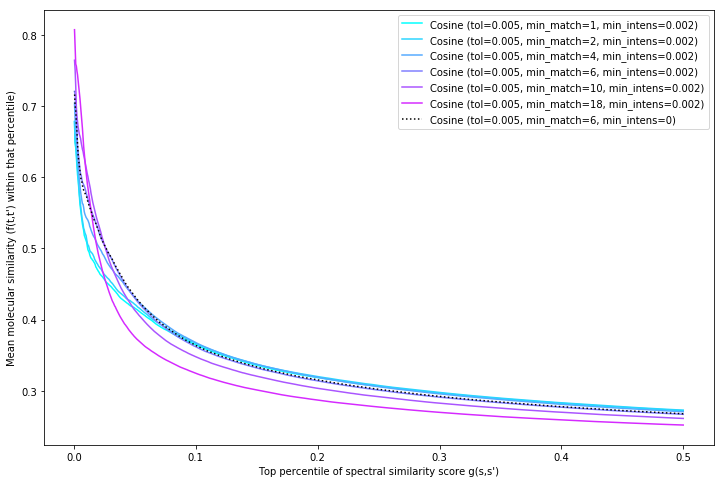

In [214]:
# Compare all:
fig, ax = plt.subplots(figsize=(12,8))
#plot_colors = ['darkcyan', 'purple', 'seagreen', 'steelblue', 'darkcyan', 'firebrick', 'darkcyan', 'purple', 'seagreen', 'steelblue', 'darkcyan', 'firebrick']
#color_sequence = ['#003f5c','#882556', '#D65113', '#ffa600', '#58508d', '#bc5090', '#2651d1', '#2f4b7c', '#ff6361', '#a05195', '#d45087']
cmap = matplotlib.cm.get_cmap('cool') #('plasma') #('Spectral')

#selection = [0,1,2,3,4,5,6,7,9,11,13,15,17]
selection = [0,1,3,5,9,17]
N = len(selection)
for i, select in enumerate(selection):
#for i, ref_score_cum in enumerate(ref_score_cum_collection[:-2]):
    ref_score_cum = ref_score_cum_collection[select]
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum, 
             color=cmap(i/N), #color_sequence[i], 
             label="Cosine (tol=0.005, min_match=" + str(select+1) + ", min_intens=0.002)")

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cosine_cum4,':',
         color='black',
         label="Cosine (tol=0.005, min_match=6, min_intens=0)")

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.savefig('cosine_min_match_comparison.pdf')

## Warning/Reminder:
When evaluating the effect of the min_match filtering, the initial filtering procedure for the spectra starts to play a crucial role!  
Using little or unfiltered spectra, a lot of the matching peaks will be peaks of low intensity.  
(here, however, the difference between an additional filter for peaks > min_intens=0.002 did not change a lot)

***
## 8. Some comparison plots:

'fig, ax = plt.subplots(figsize=(6,6))\nplt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_w2v, color=\'black\', label=\'Spec2Vec\')\nplt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_molnet1, color=\'purple\', label=\'mod. cosine tol=0.5\')\nplt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_molnet2, color=\'firebrick\', label=\'mod. cosine tol=0.02\')\nplt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_cosine, color=\'steelblue\', label=\'cosine tol=0.5\')\nplt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_cosine2, color=\'seagreen\', label=\'cosine tol=0.02\')\nplt.legend()\nplt.xlabel("Top percentile of spectral similarity score g(s,s\')")\nplt.ylabel("Mean molecular similarity (f(t,t\') at that percentile)")\n'

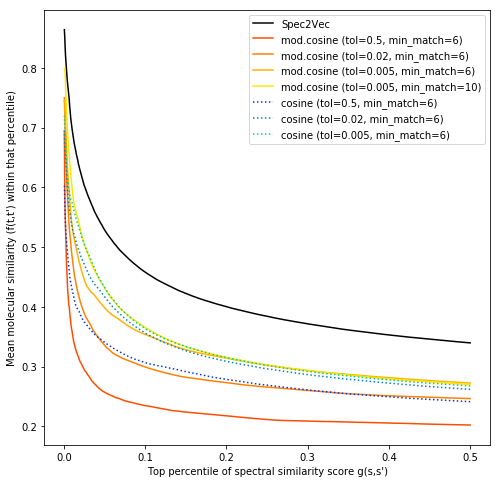

In [179]:
# Compare all:
cmap1 = matplotlib.cm.get_cmap('autumn') #('BuPu')
cmap2 = matplotlib.cm.get_cmap('winter') #('YlGn')

fig, ax = plt.subplots(figsize=(8,8))
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum, color='black',
         label='Spec2Vec')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_molnet1_cum, 
         color=cmap1(0.3),
         label='mod.cosine (tol=0.5, min_match=6)')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_molnet2_cum, 
         color=cmap1(0.5),
         label='mod.cosine (tol=0.02, min_match=6)')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_collection[5], 
         color=cmap1(0.7),
         label='mod.cosine (tol=0.005, min_match=6)')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_collection[9], 
         color=cmap1(0.9),
         label='mod.cosine (tol=0.005, min_match=10)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cosine_cum, ':', 
         color=cmap2(0.2),
         label='cosine (tol=0.5, min_match=6)')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cosine_cum2, ':',
         color=cmap2(0.5),
         label='cosine (tol=0.02, min_match=6)')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cosine_cum4, ':',
         color=cmap2(0.8),
         label='cosine (tol=0.005, min_match=6)')

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.savefig('Top_percentile_comparison.pdf')

In [319]:
np.save('cosine_percentile_tol0005_minmatch6.npy', ref_score_cosine_cum4)
np.save('cosine_percentile_tol002_minmatch6.npy', ref_score_cosine_cum2)

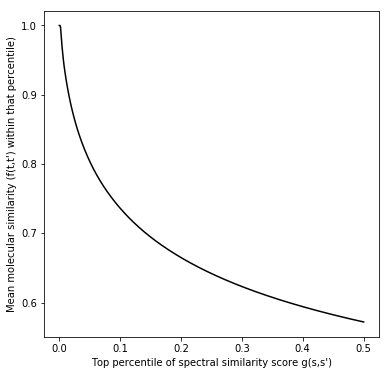

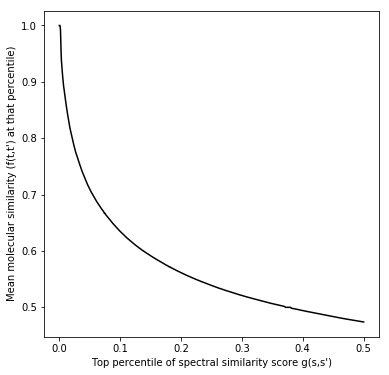

In [312]:
#H, edges = np.histogramdd([B, B], bins = (bins_x, bins_y))
ref_score_morgan3, ref_score_morgan3_cum = plot_high_sim_percentile(B, B, num_bins = 1000, show_top_percentile = 0.5)

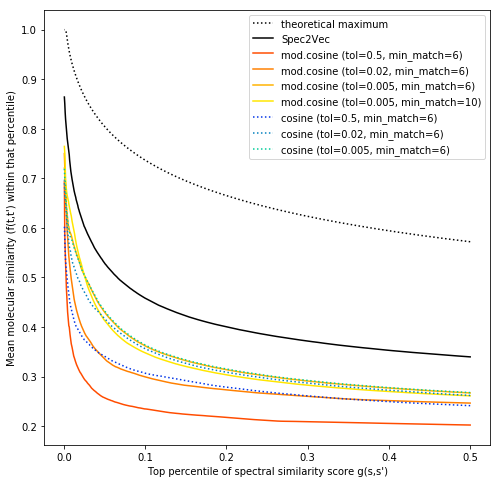

In [316]:
# Compare all:
cmap1 = matplotlib.cm.get_cmap('autumn') #('BuPu')
cmap2 = matplotlib.cm.get_cmap('winter') #('YlGn')

fig, ax = plt.subplots(figsize=(8,8))
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_morgan3_cum, ':', color='black', 
         label='theoretical maximum')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum, color='black',
         label='Spec2Vec')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_molnet1_cum, color=cmap1(0.3),
         label='mod.cosine (tol=0.5, min_match=6)')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_molnet2_cum, color=cmap1(0.5),
         label='mod.cosine (tol=0.02, min_match=6)')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_collection[5], color=cmap1(0.7),
         label='mod.cosine (tol=0.005, min_match=6)')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_collection[9], color=cmap1(0.9),
         label='mod.cosine (tol=0.005, min_match=10)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cosine_cum, ':', color=cmap2(0.2),
         label='cosine (tol=0.5, min_match=6)')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cosine_cum2, ':',color=cmap2(0.5),
         label='cosine (tol=0.02, min_match=6)')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cosine_cum4, ':',color=cmap2(0.8),
         label='cosine (tol=0.005, min_match=6)')

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.savefig('Top_percentile_comparison2.pdf')

### Plot to compare molecular similarity of closest spectral matches

In [191]:
MS_measure.get_centroid_similarity(num_hits=25, method='cosine')

Calculated distances between  9550  documents.


In [248]:
avg_best_scores, labels = MS_functions.compare_best_results(spectra_dict, 
                                                             spectra,
                                                             MS_measure,
                                                             M_sim_morgan3,
                                                             M_sim_cosine2,
                                                             num_candidates = 25,
                                                             similarity_method = ["centroid"])

In [251]:
avg_best_scores2, labels2 = MS_functions.compare_best_results(spectra_dict, 
                                                             spectra,
                                                             MS_measure,
                                                             M_sim_morgan3,
                                                             M_sim_molnet2,
                                                             num_candidates = 25,
                                                             similarity_method = ["centroid"])

In [252]:
avg_best_scores_all= [avg_best_scores[0], avg_best_scores[1], avg_best_scores2[1], avg_best_scores[2]]

In [253]:
labels = ['Tanimoto (best)', 'Modified cosine (tol=0.02, min_match=6)', 'Cosine (tol=0.02, min_match=6)', 'Spectrum similarity (centroid)']


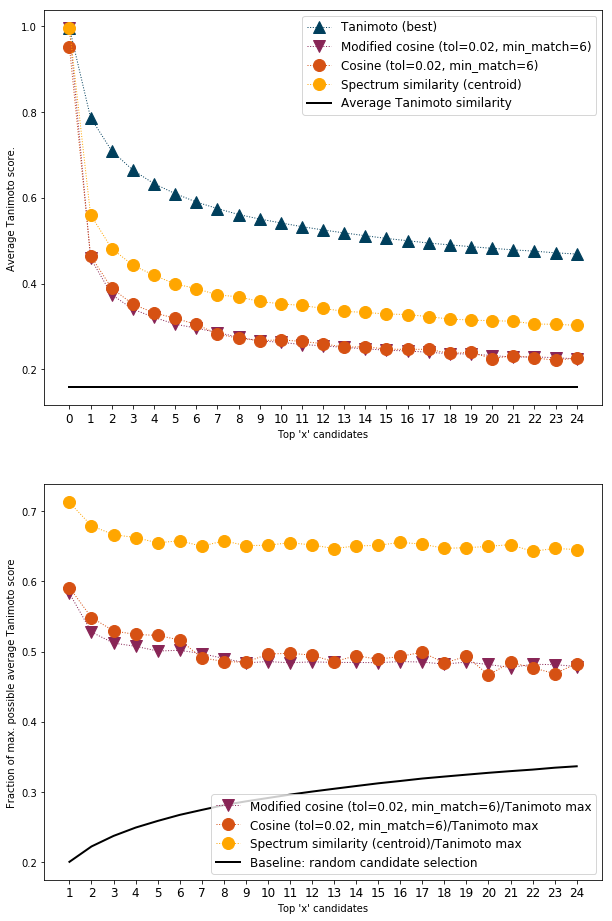

In [254]:
MS_functions.plot_best_results(avg_best_scores_all,  
                              labels,
                              tanimoto_similarities,
                              filename = 'MS_similarity_measures_comparison_001.pdf')

In [184]:
csvfile = PATH_MS_DATA + "ClassyFire_InputforCytoscape_GNPSLibraries.csv"     

import pandas as pd
mol_classes = pd.read_csv(csvfile, delimiter='\t')  

In [185]:
list_mol_superclasses = []
list_mol_classes = []
list_mol_subclasses = []

for spectrum in spectra:
    subtable = mol_classes[mol_classes['inchikey'].str.contains(spectrum.metadata['inchikey'])]
    
    if subtable.shape[0] > 0:  # i.e. if match was found
        list_mol_superclasses.append(subtable['superclass'].values[0])
        list_mol_classes.append(subtable['class'].values[0])
        list_mol_subclasses.append(subtable['subclass'].values[0])
    else:
        list_mol_superclasses.append('None')
        list_mol_classes.append('None')
        list_mol_subclasses.append('None')
    
# Remove nan's
list_mol_superclasses = ['None' if x is np.nan else x for x in list_mol_superclasses]
list_mol_classes = ['None' if x is np.nan else x for x in list_mol_classes]
list_mol_subclasses = ['None' if x is np.nan else x for x in list_mol_subclasses]

### List most similar candidates (and count their properties...)

In [180]:
#MS_measure.get_centroid_distances(num_hits=25, method='cosine')

# Compare word2vec/similarity score
list_similars_ctr_idx = MS_measure.list_similars_ctr_idx
list_similars_ctr = MS_measure.list_similars_ctr

In [181]:
IDs = np.arange(len(spectra))
np.random.choice(IDs, size = 10, replace=False)

array([3732, 3674,  706, 6046, 5061, 9104, 6938, 3195, 6695, 3839])

In [249]:
IDs = np.arange(10)
IDs_new = np.delete(IDs, 5)
IDs_new[1:]

array([1, 2, 3, 4, 6, 7, 8, 9])

In [229]:
num_candidates = 25
cosine_similars_idx = np.zeros((len(spectra), num_candidates))
molnet_similars_idx = np.zeros((len(spectra), num_candidates))
morgan3_similars_idx = np.zeros((len(spectra), num_candidates))
random_similars_idx = np.zeros((len(spectra), num_candidates))

IDs = np.arange(len(spectra))

for i in range(len(spectra)):        
    # Compare to cosine score
    cosine_candidates = M_sim_cosine2[i,:].argsort()[-num_candidates:][::-1]
    
    # Compare to molecular networking score
    molnet_candidates = M_sim_molnet2[i,:].argsort()[-num_candidates:][::-1]

    # Compare to maximum possible Tanimoto score
    morgan3_candidates = M_sim_morgan3[i,:].argsort()[-num_candidates:][::-1] 
    
    # Compare to random choice score
    IDs_new = np.delete(IDs, i)
    random_candidates = np.random.choice(IDs, size = num_candidates-1, replace=False)
    
    cosine_similars_idx[i,:] = cosine_candidates
    molnet_similars_idx[i,:] = molnet_candidates
    morgan3_similars_idx[i,:] = morgan3_candidates
    random_similars_idx[i,0] = i
    random_similars_idx[i,1:] = random_candidates

In [230]:
num_links = 10

num_mol_classes_w2v = []
num_mol_classes_cosine = []
num_mol_classes_molnet = []
num_mol_classes_morgan3 = []
num_mol_classes_random = []

for i in range(len(spectra)):
    candidate_classes = [list_mol_classes[x] for x in list_similars_ctr_idx[i,:num_links+1] if not list_mol_classes[x] == "None"]
    num_mol_classes_w2v.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in cosine_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_cosine.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in molnet_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_molnet.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in morgan3_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_morgan3.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in random_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_random.append(len(set(candidate_classes)))

In [233]:
hist_w2v, _ = np.histogram(num_mol_classes_w2v, bins = np.arange(num_links+2))
hist_cosine, _ = np.histogram(num_mol_classes_cosine, bins = np.arange(num_links+2))
hist_molnet, _ = np.histogram(num_mol_classes_molnet, bins = np.arange(num_links+2))
hist_morgan3, _ = np.histogram(num_mol_classes_morgan3, bins = np.arange(num_links+2))
hist_random, _ = np.histogram(num_mol_classes_random, bins = np.arange(num_links+2))

hist_w2v = 100*hist_w2v/np.sum(hist_w2v)
hist_cosine = 100*hist_cosine/np.sum(hist_cosine)
hist_molnet = 100*hist_molnet/np.sum(hist_molnet)
hist_morgan3 = 100*hist_morgan3/np.sum(hist_morgan3)
hist_random = 100*hist_random/np.sum(hist_random)

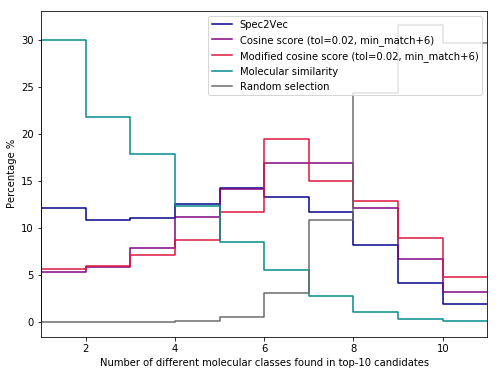

In [240]:
fig, ax = plt.subplots(figsize=(8,6))
plt.step(np.arange(1,num_links+2), hist_w2v[:], 'darkblue', label='Spec2Vec')
plt.step(np.arange(1,num_links+2), hist_cosine[:], 'purple', label='Cosine score (tol=0.02, min_match+6)')
plt.step(np.arange(1,num_links+2), hist_molnet[:], 'crimson', label='Modified cosine score (tol=0.02, min_match+6)')
plt.step(np.arange(1,num_links+2), hist_morgan3[:], 'darkcyan', label='Molecular similarity')
plt.step(np.arange(1,num_links+2), hist_random[:], 'dimgrey', label='Random selection')
plt.legend(loc='upper right')
plt.xlabel('Number of different molecular classes found in top-10 candidates')
plt.ylabel('Percentage %')
plt.xlim(1,num_links+1)
plt.savefig('comparison_mol_class.pdf')

In [241]:
num_candidates = 25
cosine_similars_idx = np.zeros((len(spectra), num_candidates))
molnet_similars_idx = np.zeros((len(spectra), num_candidates))
morgan3_similars_idx = np.zeros((len(spectra), num_candidates))
random_similars_idx = np.zeros((len(spectra), num_candidates))

IDs = np.arange(len(spectra))

for i in range(len(spectra)):        
    # Compare to cosine score
    cosine_candidates = M_sim_cosine4[i,:].argsort()[-num_candidates:][::-1]
    
    # Compare to molecular networking score
    molnet_candidates = M_sim_molnet3_minmatch6[i,:].argsort()[-num_candidates:][::-1]

    # Compare to maximum possible Tanimoto score
    morgan3_candidates = M_sim_morgan3[i,:].argsort()[-num_candidates:][::-1] 
    
    # Compare to random choice score
    IDs_new = np.delete(IDs, i)
    random_candidates = np.random.choice(IDs, size = num_candidates-1, replace=False)
    
    cosine_similars_idx[i,:] = cosine_candidates
    molnet_similars_idx[i,:] = molnet_candidates
    morgan3_similars_idx[i,:] = morgan3_candidates
    random_similars_idx[i,0] = i
    random_similars_idx[i,1:] = random_candidates

In [242]:
num_links = 10

num_mol_classes_w2v = []
num_mol_classes_cosine = []
num_mol_classes_molnet = []
num_mol_classes_morgan3 = []
num_mol_classes_random = []

for i in range(len(spectra)):
    candidate_classes = [list_mol_classes[x] for x in list_similars_ctr_idx[i,:num_links+1] if not list_mol_classes[x] == "None"]
    num_mol_classes_w2v.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in cosine_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_cosine.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in molnet_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_molnet.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in morgan3_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_morgan3.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in random_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_random.append(len(set(candidate_classes)))

In [243]:
hist_w2v, _ = np.histogram(num_mol_classes_w2v, bins = np.arange(num_links+2))
hist_cosine, _ = np.histogram(num_mol_classes_cosine, bins = np.arange(num_links+2))
hist_molnet, _ = np.histogram(num_mol_classes_molnet, bins = np.arange(num_links+2))
hist_morgan3, _ = np.histogram(num_mol_classes_morgan3, bins = np.arange(num_links+2))
hist_random, _ = np.histogram(num_mol_classes_random, bins = np.arange(num_links+2))

hist_w2v = 100*hist_w2v/np.sum(hist_w2v)
hist_cosine = 100*hist_cosine/np.sum(hist_cosine)
hist_molnet = 100*hist_molnet/np.sum(hist_molnet)
hist_morgan3 = 100*hist_morgan3/np.sum(hist_morgan3)
hist_random = 100*hist_random/np.sum(hist_random)

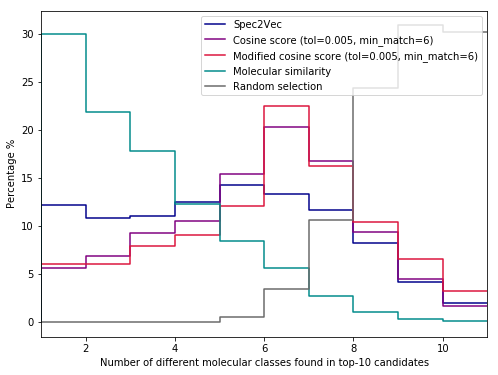

In [245]:
fig, ax = plt.subplots(figsize=(8,6))
plt.step(np.arange(1,num_links+2), hist_w2v[:], 'darkblue', label='Spec2Vec')
plt.step(np.arange(1,num_links+2), hist_cosine[:], 'purple', label='Cosine score (tol=0.005, min_match=6)')
plt.step(np.arange(1,num_links+2), hist_molnet[:], 'crimson', label='Modified cosine score (tol=0.005, min_match=6)')
plt.step(np.arange(1,num_links+2), hist_morgan3[:], 'darkcyan', label='Molecular similarity')
plt.step(np.arange(1,num_links+2), hist_random[:], 'dimgrey', label='Random selection')
plt.legend(loc='upper right')
plt.xlabel('Number of different molecular classes found in top-10 candidates')
plt.ylabel('Percentage %')
plt.xlim(1,num_links+1)
plt.savefig('comparison_mol_class_01.pdf')

In [262]:
num_links = 20

num_mol_classes_w2v = []
num_mol_classes_cosine = []
num_mol_classes_molnet = []
num_mol_classes_morgan3 = []
num_mol_classes_random = []

for i in range(len(spectra)):
    candidate_classes = [list_mol_classes[x] for x in list_similars_ctr_idx[i,:num_links+1] if not list_mol_classes[x] == "None"]
    num_mol_classes_w2v.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in cosine_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_cosine.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in molnet_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_molnet.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in morgan3_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_morgan3.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in random_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_random.append(len(set(candidate_classes)))

In [263]:
hist_w2v, _ = np.histogram(num_mol_classes_w2v, bins = np.arange(num_links+2))
hist_cosine, _ = np.histogram(num_mol_classes_cosine, bins = np.arange(num_links+2))
hist_molnet, _ = np.histogram(num_mol_classes_molnet, bins = np.arange(num_links+2))
hist_morgan3, _ = np.histogram(num_mol_classes_morgan3, bins = np.arange(num_links+2))
hist_random, _ = np.histogram(num_mol_classes_random, bins = np.arange(num_links+2))

hist_w2v = 100*hist_w2v/np.sum(hist_w2v)
hist_cosine = 100*hist_cosine/np.sum(hist_cosine)
hist_molnet = 100*hist_molnet/np.sum(hist_molnet)
hist_morgan3 = 100*hist_morgan3/np.sum(hist_morgan3)
hist_random = 100*hist_random/np.sum(hist_random)

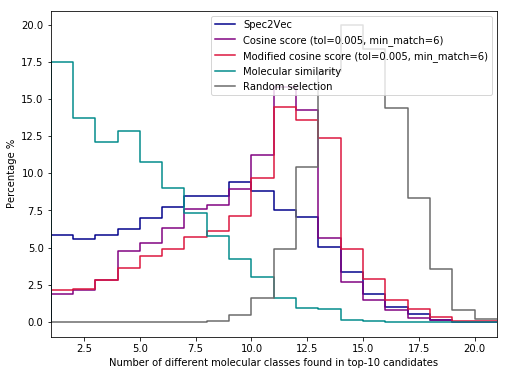

In [264]:
fig, ax = plt.subplots(figsize=(8,6))
plt.step(np.arange(1,num_links+2), hist_w2v[:], 'darkblue', label='Spec2Vec')
plt.step(np.arange(1,num_links+2), hist_cosine[:], 'purple', label='Cosine score (tol=0.005, min_match=6)')
plt.step(np.arange(1,num_links+2), hist_molnet[:], 'crimson', label='Modified cosine score (tol=0.005, min_match=6)')
plt.step(np.arange(1,num_links+2), hist_morgan3[:], 'darkcyan', label='Molecular similarity')
plt.step(np.arange(1,num_links+2), hist_random[:], 'dimgrey', label='Random selection')
plt.legend(loc='upper right')
plt.xlabel('Number of different molecular classes found in top-10 candidates')
plt.ylabel('Percentage %')
plt.xlim(1,num_links+1)
plt.savefig('comparison_mol_class_01.pdf')

In [246]:
num_links = 10

num_mol_superclasses_w2v = []
num_mol_superclasses_cosine = []
num_mol_superclasses_molnet = []
num_mol_superclasses_morgan3 = []
num_mol_superclasses_random = []

for i in range(len(spectra)):
    candidate_classes = [list_mol_superclasses[x] for x in list_similars_ctr_idx[i,:num_links+1] if not list_mol_superclasses[x] == "None"]
    num_mol_superclasses_w2v.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_superclasses[int(x)] for x in cosine_similars_idx[i,:num_links+1] if not list_mol_superclasses[int(x)] == "None"]
    num_mol_superclasses_cosine.append(len(set(candidate_classes)))
        
    candidate_classes = [list_mol_superclasses[int(x)] for x in molnet_similars_idx[i,:num_links+1] if not list_mol_superclasses[int(x)] == "None"]
    num_mol_superclasses_molnet.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_superclasses[int(x)] for x in morgan3_similars_idx[i,:num_links+1] if not list_mol_superclasses[int(x)] == "None"]
    num_mol_superclasses_morgan3.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_superclasses[int(x)] for x in random_similars_idx[i,:num_links+1] if not list_mol_superclasses[int(x)] == "None"]
    num_mol_superclasses_random.append(len(set(candidate_classes)))

In [256]:
hist_w2v, _ = np.histogram(num_mol_superclasses_w2v, bins = np.arange(num_links+2))
hist_cosine, _ = np.histogram(num_mol_superclasses_cosine, bins = np.arange(num_links+2))
hist_molnet, _ = np.histogram(num_mol_superclasses_molnet, bins = np.arange(num_links+2))
hist_morgan3, _ = np.histogram(num_mol_superclasses_morgan3, bins = np.arange(num_links+2))
hist_random, _ = np.histogram(num_mol_superclasses_random, bins = np.arange(num_links+2))

hist_w2v = 100*hist_w2v/np.sum(hist_w2v)
hist_cosine = 100*hist_cosine/np.sum(hist_cosine)
hist_molnet = 100*hist_molnet/np.sum(hist_molnet)
hist_morgan3 = 100*hist_morgan3/np.sum(hist_morgan3)
hist_random = 100*hist_random/np.sum(hist_random)

In [258]:
hist_w2v, hist_cosine, hist_molnet

(array([ 0.        , 19.36125654, 20.        , 24.68062827, 19.89528796,
        11.43455497,  3.92670157,  0.64921466,  0.05235602,  0.        ,
         0.        ]),
 array([ 0.        ,  8.84816754, 14.73298429, 20.43979058, 23.88481675,
        22.71204188,  8.32460733,  1.01570681,  0.04188482,  0.        ,
         0.        ]),
 array([ 0.        ,  8.97382199, 12.41884817, 19.43455497, 23.2460733 ,
        26.76439791,  8.21989529,  0.89005236,  0.05235602,  0.        ,
         0.        ]))

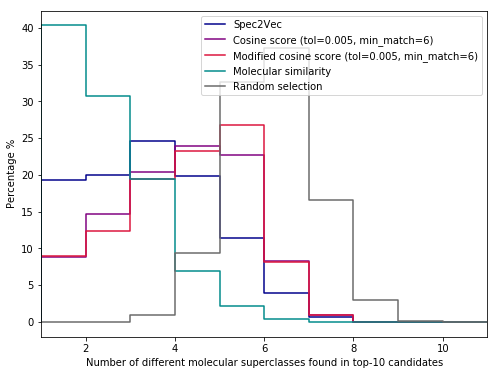

In [249]:
fig, ax = plt.subplots(figsize=(8,6))
plt.step(np.arange(1,num_links+2), hist_w2v[:], 'darkblue', label='Spec2Vec')
plt.step(np.arange(1,num_links+2), hist_cosine[:], 'purple', label='Cosine score (tol=0.005, min_match=6)')
plt.step(np.arange(1,num_links+2), hist_molnet[:], 'crimson', label='Modified cosine score (tol=0.005, min_match=6)')
plt.step(np.arange(1,num_links+2), hist_morgan3[:], 'darkcyan', label='Molecular similarity')
plt.step(np.arange(1,num_links+2), hist_random[:], 'dimgrey', label='Random selection')
plt.legend(loc='upper right')
plt.xlabel('Number of different molecular superclasses found in top-10 candidates')
plt.ylabel('Percentage %')
plt.xlim(1,num_links+1)
plt.savefig('comparison_mol_superclass.pdf')

In [280]:
num_links = 10

num_mol_subclasses_w2v = []
num_mol_subclasses_cosine = []
num_mol_subclasses_molnet = []
num_mol_subclasses_morgan3 = []
num_mol_subclasses_random = []

for i in range(len(spectra)):
    candidate_classes = [list_mol_subclasses[x] for x in list_similars_ctr_idx[i,:num_links+1] if not list_mol_subclasses[x] == "None"]
    num_mol_subclasses_w2v.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_subclasses[int(x)] for x in cosine_similars_idx[i,:num_links+1] if not list_mol_subclasses[int(x)] == "None"]
    num_mol_subclasses_cosine.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_subclasses[int(x)] for x in molnet_similars_idx[i,:num_links+1] if not list_mol_subclasses[int(x)] == "None"]
    num_mol_subclasses_molnet.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_subclasses[int(x)] for x in morgan3_similars_idx[i,:num_links+1] if not list_mol_subclasses[int(x)] == "None"]
    num_mol_subclasses_morgan3.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_subclasses[int(x)] for x in random_similars_idx[i,:num_links+1] if not list_mol_subclasses[int(x)] == "None"]
    num_mol_subclasses_random.append(len(set(candidate_classes)))

In [281]:
hist_w2v, _ = np.histogram(num_mol_subclasses_w2v, bins = np.arange(num_links+2))
hist_cosine, _ = np.histogram(num_mol_subclasses_cosine, bins = np.arange(num_links+2))
hist_molnet, _ = np.histogram(num_mol_subclasses_molnet, bins = np.arange(num_links+2))
hist_morgan3, _ = np.histogram(num_mol_subclasses_morgan3, bins = np.arange(num_links+2))
hist_random, _ = np.histogram(num_mol_subclasses_random, bins = np.arange(num_links+2))

hist_w2v = 100*hist_w2v/np.sum(hist_w2v)
hist_cosine = 100*hist_cosine/np.sum(hist_cosine)
hist_molnet = 100*hist_molnet/np.sum(hist_molnet)
hist_morgan3 = 100*hist_morgan3/np.sum(hist_morgan3)
hist_random = 100*hist_random/np.sum(hist_random)

In [283]:
hist_w2v, hist_cosine, hist_molnet

(array([ 1.7591623 , 10.15706806,  9.88481675, 11.03664921, 14.54450262,
        15.34031414, 15.27748691, 10.71204188,  6.79581152,  3.46596859,
         1.02617801]),
 array([ 0.48167539,  4.83769634,  6.70157068,  8.04188482, 11.94764398,
        15.48691099, 21.40314136, 19.22513089,  8.32460733,  2.64921466,
         0.90052356]),
 array([ 0.65968586,  5.2460733 ,  5.84293194,  6.84816754,  9.88481675,
        14.7434555 , 19.27748691, 23.72774869,  9.10994764,  3.41361257,
         1.2460733 ]))

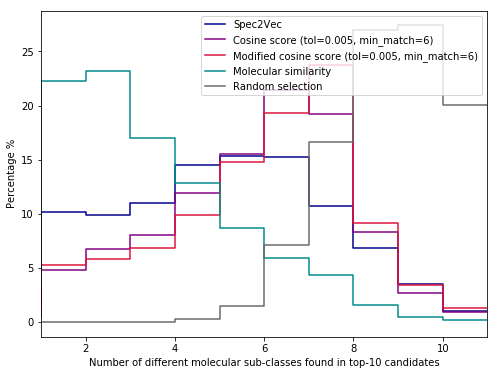

In [282]:
fig, ax = plt.subplots(figsize=(8,6))
plt.step(np.arange(1,num_links+2), hist_w2v[:], 'darkblue', label='Spec2Vec')
plt.step(np.arange(1,num_links+2), hist_cosine[:], 'purple', label='Cosine score (tol=0.005, min_match=6)')
plt.step(np.arange(1,num_links+2), hist_molnet[:], 'crimson', label='Modified cosine score (tol=0.005, min_match=6)')
plt.step(np.arange(1,num_links+2), hist_morgan3[:], 'darkcyan', label='Molecular similarity')
plt.step(np.arange(1,num_links+2), hist_random[:], 'dimgrey', label='Random selection')
plt.legend(loc='upper right')
plt.xlabel('Number of different molecular sub-classes found in top-10 candidates')
plt.ylabel('Percentage %')
plt.xlim(1,num_links+1)
plt.savefig('comparison_mol_subclass.pdf')

In [277]:
num_links = 20

num_mol_subclasses_w2v = []
num_mol_subclasses_cosine = []
num_mol_subclasses_molnet = []
num_mol_subclasses_morgan3 = []
num_mol_subclasses_random = []

for i in range(len(spectra)):
    candidate_classes = [list_mol_subclasses[x] for x in list_similars_ctr_idx[i,:num_links+1] if not list_mol_subclasses[x] == "None"]
    num_mol_subclasses_w2v.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_subclasses[int(x)] for x in cosine_similars_idx[i,:num_links+1] if not list_mol_subclasses[int(x)] == "None"]
    num_mol_subclasses_cosine.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_subclasses[int(x)] for x in molnet_similars_idx[i,:num_links+1] if not list_mol_subclasses[int(x)] == "None"]
    num_mol_subclasses_molnet.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_subclasses[int(x)] for x in morgan3_similars_idx[i,:num_links+1] if not list_mol_subclasses[int(x)] == "None"]
    num_mol_subclasses_morgan3.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_subclasses[int(x)] for x in random_similars_idx[i,:num_links+1] if not list_mol_subclasses[int(x)] == "None"]
    num_mol_subclasses_random.append(len(set(candidate_classes)))

In [278]:
hist_w2v, _ = np.histogram(num_mol_subclasses_w2v, bins = np.arange(num_links+2))
hist_cosine, _ = np.histogram(num_mol_subclasses_cosine, bins = np.arange(num_links+2))
hist_molnet, _ = np.histogram(num_mol_subclasses_molnet, bins = np.arange(num_links+2))
hist_morgan3, _ = np.histogram(num_mol_subclasses_morgan3, bins = np.arange(num_links+2))
hist_random, _ = np.histogram(num_mol_subclasses_random, bins = np.arange(num_links+2))

hist_w2v = 100*hist_w2v/np.sum(hist_w2v)
hist_cosine = 100*hist_cosine/np.sum(hist_cosine)
hist_molnet = 100*hist_molnet/np.sum(hist_molnet)
hist_morgan3 = 100*hist_morgan3/np.sum(hist_morgan3)
hist_random = 100*hist_random/np.sum(hist_random)

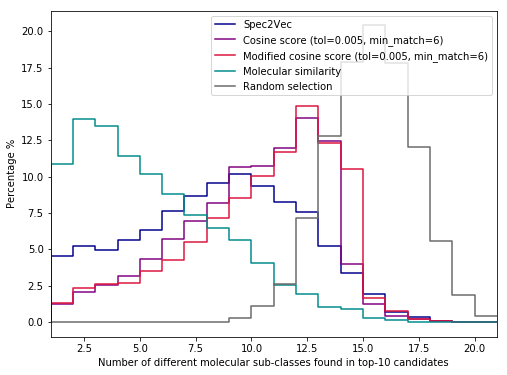

In [279]:
fig, ax = plt.subplots(figsize=(8,6))
plt.step(np.arange(1,num_links+2), hist_w2v[:], 'darkblue', label='Spec2Vec')
plt.step(np.arange(1,num_links+2), hist_cosine[:], 'purple', label='Cosine score (tol=0.005, min_match=6)')
plt.step(np.arange(1,num_links+2), hist_molnet[:], 'crimson', label='Modified cosine score (tol=0.005, min_match=6)')
plt.step(np.arange(1,num_links+2), hist_morgan3[:], 'darkcyan', label='Molecular similarity')
plt.step(np.arange(1,num_links+2), hist_random[:], 'dimgrey', label='Random selection')
plt.legend(loc='upper right')
plt.xlabel('Number of different molecular sub-classes found in top-10 candidates')
plt.ylabel('Percentage %')
plt.xlim(1,num_links+1)
plt.savefig('comparison_mol_subclass.pdf')

# Explore ways to compare the different scores.

# Below: many plotting tests that were done...
(meaning that from here on the notebook is not really up to date)

#### 1) Draw histograms of Tanimoto/Dice scores for the highest scoring similarity pairs. 

#### Baseline: Histogram of all Tanimoto/Dice scores

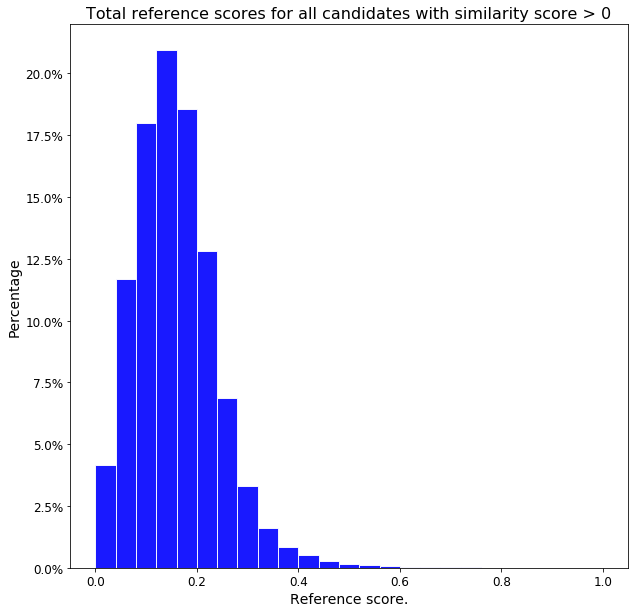

In [17]:
n, bins = MS_functions.similarity_histogram(tanimoto_similarities, tanimoto_similarities, 0, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_baseline.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

#### Top 10000 entries (+ top 5000 candidates) for Word2Vec/Centroid score:

Set similarity threshold to:  0.8505918971390208


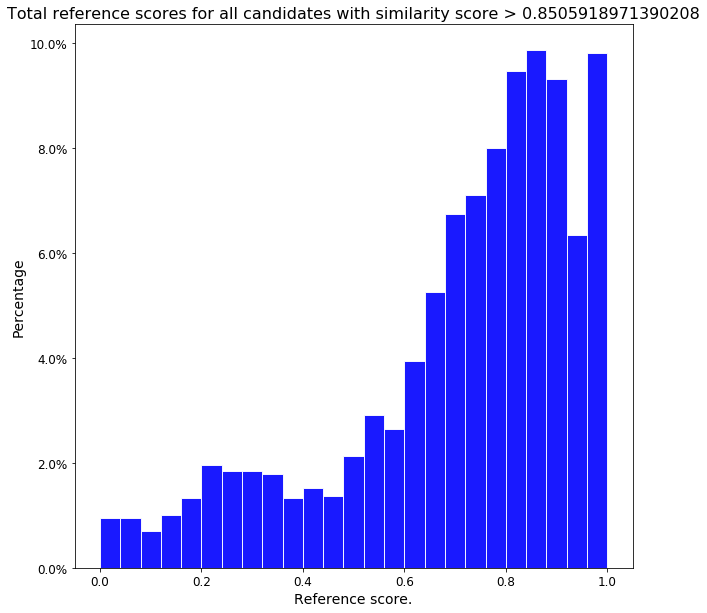

Percentage of highly similar molecules within selection:  83.4 %


In [16]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### Compare MolNet score and centroid/Word2Vec score

In [18]:
from matplotlib import pyplot as plt
import matplotlib

In [25]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

Text(0, 0.5, "molecular similarity (f(t,t'))")

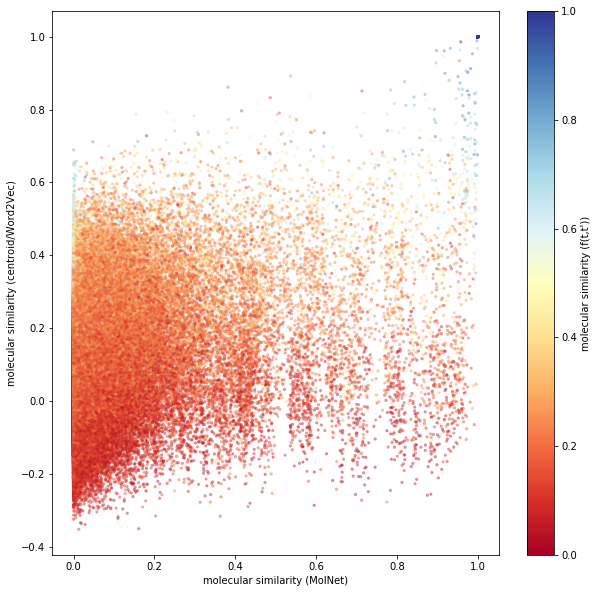

In [21]:
# Agreement between Word2Vec and MolNet similarity.
fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')
ax.scatter(molnet_sim[:500,:500], M_sim_ctr[:500,:500], s=5, c=tanimoto_similarities[:500,:500], cmap=cm, alpha=0.2)
plt.xlabel("molecular similarity (MolNet)")
plt.ylabel("molecular similarity (centroid/Word2Vec)")

# Optionally add a colorbar
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm)
plt.ylabel("molecular similarity (f(t,t'))")

Text(0, 0.5, "molecular similarity (f(t,t'))")

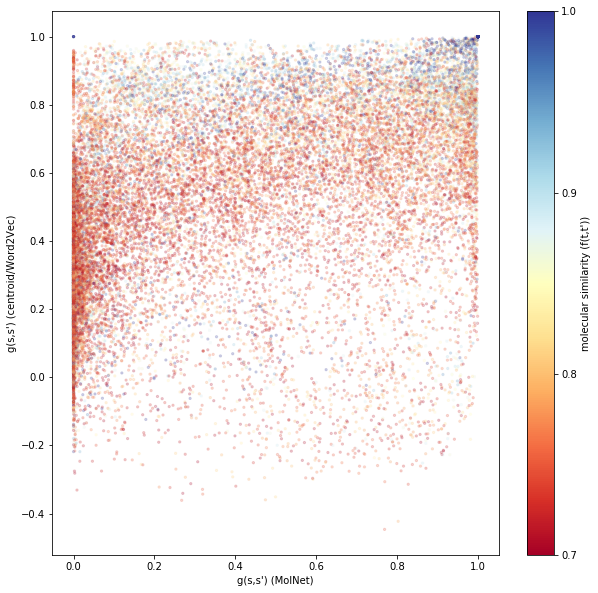

In [28]:
# Agreement between Word2Vec and MolNet similarity.
select = np.where(tanimoto_similarities > 0.7)

fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')
ax.scatter(molnet_sim[select], M_sim_ctr[select], s=5, c=tanimoto_similarities[select], cmap=cm, alpha=0.1)
plt.xlabel("g(s,s') (MolNet)")
plt.ylabel("g(s,s') (centroid/Word2Vec)")

# Optionally add a colorbar
cax, _ = matplotlib.colorbar.make_axes(ax)

cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.333, 0.666, 1])
cbar.ax.set_yticklabels(['0.7', '0.8', '0.9', '1.0'])
plt.ylabel("molecular similarity (f(t,t'))")

Text(0, 0.5, "molecular similarity (f(t,t'))")

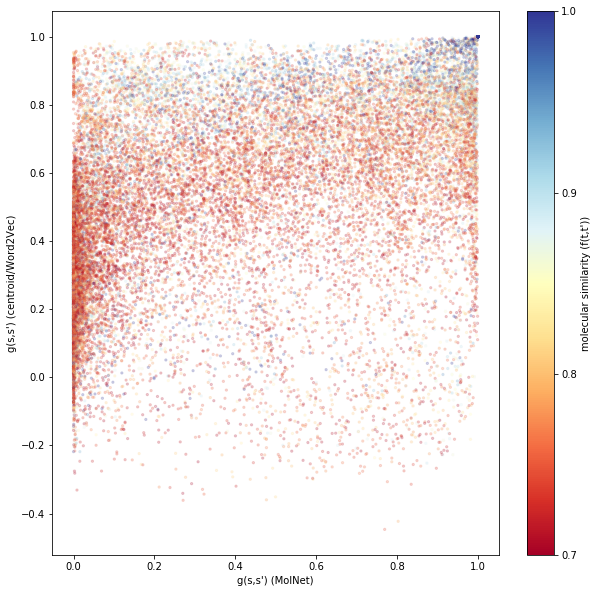

In [31]:
# Agreement between Word2Vec and MolNet similarity.
select = np.where(tanimoto_similarities > 0.7)

fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')
ax.scatter(molnet_sim_hung[select], M_sim_ctr[select], s=5, c=tanimoto_similarities[select], cmap=cm, alpha=0.1)
plt.xlabel("g(s,s') (MolNet)")
plt.ylabel("g(s,s') (centroid/Word2Vec)")

# Optionally add a colorbar
cax, _ = matplotlib.colorbar.make_axes(ax)

cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.333, 0.666, 1])
cbar.ax.set_yticklabels(['0.7', '0.8', '0.9', '1.0'])
plt.ylabel("molecular similarity (f(t,t'))")

### switch to density based plot

In [212]:
bins_xy = 10
bins_z = 100

H, edges = np.histogramdd([molnet_sim_hung.reshape(9550**2), 
                           M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_xy, bins_xy, bins_z))

In [ ]:
edges

In [213]:
data_x = []
data_y = []
data_z = []
data_z_mean = []
for i in range(bins_xy):
    for j in range(bins_xy):
        data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
        data_z.append(np.sum(H[i,j,:])/10000)
        mean_mol_score = np.sum(H[i,j,:]*(edges[2][:bins_z] + edges[2][1]/2))/(np.sum(H[i,j,:]))
        data_z_mean.append(mean_mol_score)

Text(0, 0.5, "molecular similarity (f(t,t'))")

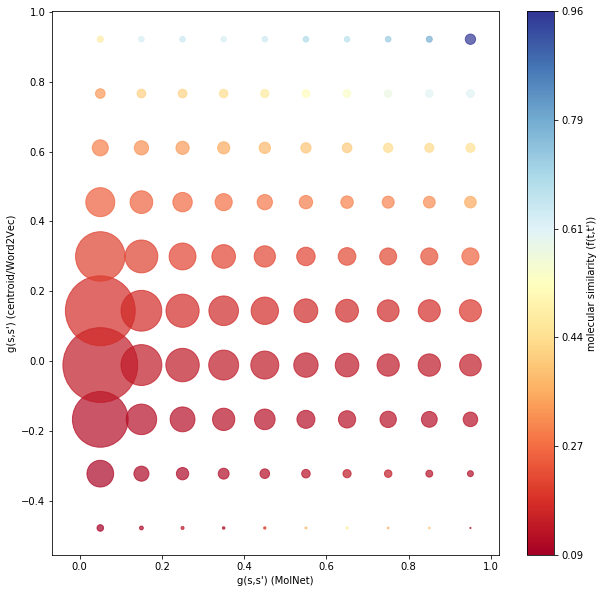

In [215]:
fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')

ax.scatter(data_x, data_y, s=100*np.array(data_z)**0.5, c=data_z_mean, cmap=cm, alpha=0.7)
plt.xlabel("g(s,s') (MolNet)")
plt.ylabel("g(s,s') (centroid/Word2Vec)")

# Optionally add a colorbar
max_color = np.max(data_z_mean)
min_color = np.min(data_z_mean)
color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.ax.set_yticklabels([x for x in list(color_ticks)])
plt.ylabel("molecular similarity (f(t,t'))")

In [278]:
bins_x = 25
bins_y = 100

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

In [279]:
data_x = []
data_y = []
data_z = []
for i in range(bins_x):
    data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
#        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
    mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
    data_y.append(mean_mol_score)
    data_z.append(np.sum(H[i,:]))

In [282]:
import seaborn as sns
import pandas as pd


In [287]:
data_df = pd.DataFrame(H, columns = edges[1][:-1], index = edges[0][:-1])

In [306]:
data_df2.head()

centroid  molscore    molnet  bin_x
0  1.000000  1.000000  1.000000     25
1  0.056423  0.283871  0.063293      9
2  0.073871  0.187135  0.004940     10
3 -0.025092  0.083832  0.006946      8
4  0.115509  0.168539  0.208322     10

In [293]:
data_df2 = pd.DataFrame(M_sim_ctr.reshape(9550**2), columns = ['centroid'])

In [295]:
data_df2['molscore'] = tanimoto_similarities.reshape(9550**2)
data_df2['molnet'] = molnet_sim_hung.reshape(9550**2)

In [304]:
min_x, max_x, np.min(bins)

(-0.5561628469642712, 1.0, 0)

In [ ]:
bins_x = 25
min_x = np.min(M_sim_ctr)
max_x = np.max(M_sim_ctr)

bins = ((M_sim_ctr.reshape(9550**2) - min_x)/(max_x- min_x) *bins_x).astype(int)
data_df2['bin_x'] = bins 

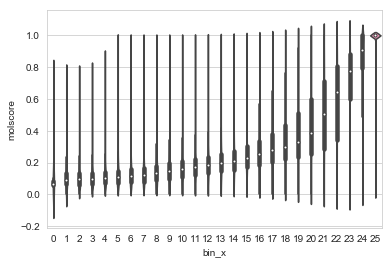

In [309]:
# Set theme
sns.set_style('whitegrid')
 
# Violin plot
sns.violinplot(x = 'bin_x', y = 'molscore', data=data_df2)

In [311]:
plt.savefig("violin_01.png")

<Figure size 432x288 with 0 Axes>

### Violin plots with that amount of data 9500^2 take long! Try bining?

### Plot to compare molecular similarity of closest spectral matches

In [114]:
avg_best_scores, labels = MS_functions.compare_best_results(spectra_dict, 
                                                             spectra,
                                                             MS_measure,
                                                             tanimoto_similarities,
                                                             cosine_sim,
                                                             num_candidates = 25,
                                                             similarity_method = ["centroid"])

In [120]:
avg_best_scores2, labels2 = MS_functions.compare_best_results(spectra_dict, 
                                                             spectra,
                                                             MS_measure,
                                                             tanimoto_similarities,
                                                             molnet_sim_hung,
                                                             num_candidates = 25,
                                                             similarity_method = ["centroid"])

In [126]:
avg_best_scores_all= [avg_best_scores[0], avg_best_scores[1], avg_best_scores2[1], avg_best_scores[2]]

In [122]:
labels = ['Tanimoto (best)', 'Cosine score', 'Modified cosine score', 'Spectrum similarity (centroid)']


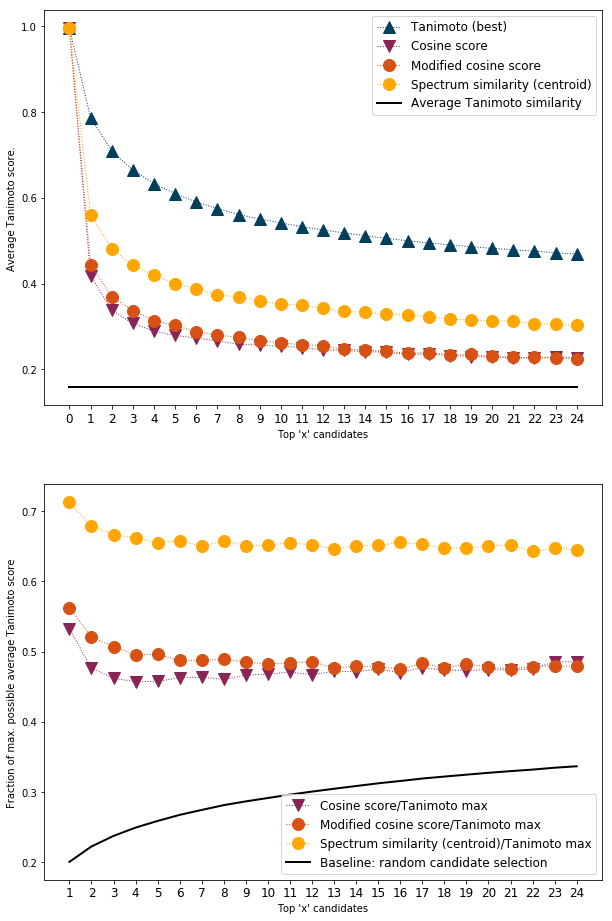

In [127]:
MS_functions.plot_best_results(avg_best_scores_all,  
                              labels,
                              tanimoto_similarities,
                              filename = 'MS_similarity_measures_comparison_test.pdf')

## List most similar candidates (and count their properties...)

In [128]:
csvfile = PATH_MS_DATA + "ClassyFire_InputforCytoscape_GNPSLibraries.csv"     

import pandas as pd
mol_classes = pd.read_csv(csvfile, delimiter='\t')  

In [129]:
list_mol_superclasses = []
list_mol_classes = []
list_mol_subclasses = []

for spectrum in spectra:
    subtable = mol_classes[mol_classes['inchikey'].str.contains(spectrum.metadata['inchikey'])]
    
    if subtable.shape[0] > 0:  # i.e. if match was found
        list_mol_superclasses.append(subtable['superclass'].values[0])
        list_mol_classes.append(subtable['class'].values[0])
        list_mol_subclasses.append(subtable['subclass'].values[0])
    else:
        list_mol_superclasses.append('None')
        list_mol_classes.append('None')
        list_mol_subclasses.append('None')
    
# Remove nan's
list_mol_superclasses = ['None' if x is np.nan else x for x in list_mol_superclasses]
list_mol_classes = ['None' if x is np.nan else x for x in list_mol_classes]
list_mol_subclasses = ['None' if x is np.nan else x for x in list_mol_subclasses]

In [217]:
MS_measure.get_centroid_similarity(num_hits=25, method='cosine')

# Compare word2vec/similarity score
list_similars_ctr_idx = MS_measure.list_similars_ctr_idx
list_similars_ctr = MS_measure.list_similars_ctr

Calculated distances between  9550  documents.


In [246]:
IDs = np.arange(len(spectra))
np.random.choice(IDs, size = 10, replace=False)

array([2731, 6149, 8446, 2494, 7521, 4637, 7934, 5517, 5644,  928])

In [249]:
IDs = np.arange(10)
IDs_new = np.delete(IDs, 5)
IDs_new[1:]

array([1, 2, 3, 4, 6, 7, 8, 9])

In [250]:
num_candidates = 25
cosine_similars_idx = np.zeros((len(spectra), num_candidates))
tanimoto_similars_idx = np.zeros((len(spectra), num_candidates))
random_similars_idx = np.zeros((len(spectra), num_candidates))

IDs = np.arange(len(spectra))

for i in range(len(spectra)):        
    # Compare to molecular networking score
    cosine_candidates = cosine_sim[i,:].argsort()[-num_candidates:][::-1]

    # Compare to maximum possible Tanimoto score
    tanimoto_candidates = tanimoto_similarities[i,:].argsort()[-num_candidates:][::-1] 
    
    # Compare to random choice score
    IDs_new = np.delete(IDs, i)
    random_candidates = np.random.choice(IDs, size = num_candidates-1, replace=False)
    
    cosine_similars_idx[i,:] = cosine_candidates
    tanimoto_similars_idx[i,:] = tanimoto_candidates
    random_similars_idx[i,0] = i
    random_similars_idx[i,1:] = random_candidates

In [251]:
num_links = 10
num_mol_classes_w2v = []
num_mol_classes_cosine = []
num_mol_classes_tanimoto = []
num_mol_classes_random = []
for i in range(len(spectra)):
    candidate_classes = [list_mol_classes[x] for x in list_similars_ctr_idx[i,:num_links+1] if not list_mol_classes[x] == "None"]
    num_mol_classes_w2v.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in cosine_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_cosine.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in tanimoto_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_tanimoto.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in random_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_random.append(len(set(candidate_classes)))

In [253]:
hist_w2v, _ = np.histogram(num_mol_classes_w2v, bins = np.arange(num_links+2))
hist_cosine, _ = np.histogram(num_mol_classes_cosine, bins = np.arange(num_links+2))
hist_tanimoto, _ = np.histogram(num_mol_classes_tanimoto, bins = np.arange(num_links+2))
hist_random, _ = np.histogram(num_mol_classes_random, bins = np.arange(num_links+2))

hist_w2v = 100*hist_w2v/np.sum(hist_w2v)
hist_cosine = 100*hist_cosine/np.sum(hist_cosine)
hist_tanimoto = 100*hist_tanimoto/np.sum(hist_tanimoto)
hist_random = 100*hist_random/np.sum(hist_random)

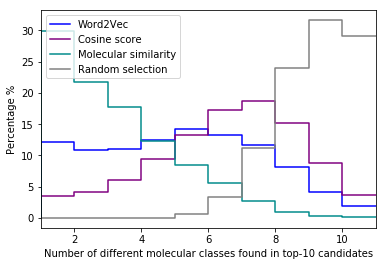

In [255]:
plt.step(np.arange(1,num_links+2), hist_w2v[:], 'blue', label='Word2Vec')
plt.step(np.arange(1,num_links+2), hist_cosine[:], 'purple', label='Cosine score')
plt.step(np.arange(1,num_links+2), hist_tanimoto[:], 'darkcyan', label='Molecular similarity')
plt.step(np.arange(1,num_links+2), hist_random[:], 'grey', label='Random selection')
plt.legend()
plt.xlabel('Number of different molecular classes found in top-10 candidates')
plt.ylabel('Percentage %')
plt.xlim(1,num_links+1)
plt.savefig('comparison_mol_class.pdf')

In [256]:
num_mol_superclasses_w2v = []
num_mol_superclasses_cosine = []
num_mol_superclasses_tanimoto = []
num_mol_superclasses_random = []
for i in range(len(spectra)):
    candidate_classes = [list_mol_superclasses[x] for x in list_similars_ctr_idx[i,:num_links+1] if not list_mol_superclasses[x] == "None"]
    num_mol_superclasses_w2v.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_superclasses[int(x)] for x in cosine_similars_idx[i,:num_links+1] if not list_mol_superclasses[int(x)] == "None"]
    num_mol_superclasses_cosine.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_superclasses[int(x)] for x in tanimoto_similars_idx[i,:num_links+1] if not list_mol_superclasses[int(x)] == "None"]
    num_mol_superclasses_tanimoto.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_superclasses[int(x)] for x in random_similars_idx[i,:num_links+1] if not list_mol_superclasses[int(x)] == "None"]
    num_mol_superclasses_random.append(len(set(candidate_classes)))

In [257]:
hist_w2v, _ = np.histogram(num_mol_superclasses_w2v, bins = np.arange(num_links+2))
hist_cosine, _ = np.histogram(num_mol_superclasses_cosine, bins = np.arange(num_links+2))
hist_tanimoto, _ = np.histogram(num_mol_superclasses_tanimoto, bins = np.arange(num_links+2))
hist_random, _ = np.histogram(num_mol_superclasses_random, bins = np.arange(num_links+2))

hist_w2v = 100*hist_w2v/np.sum(hist_w2v)
hist_cosine = 100*hist_cosine/np.sum(hist_cosine)
hist_tanimoto = 100*hist_tanimoto/np.sum(hist_tanimoto)
hist_random = 100*hist_random/np.sum(hist_random)

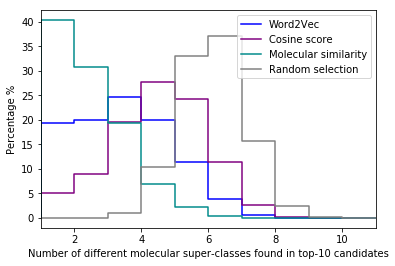

In [258]:
plt.step(np.arange(1,num_links+2), hist_w2v[:], 'blue', label='Word2Vec')
plt.step(np.arange(1,num_links+2), hist_cosine[:], 'purple', label='Cosine score')
plt.step(np.arange(1,num_links+2), hist_tanimoto[:], 'darkcyan', label='Molecular similarity')
plt.step(np.arange(1,num_links+2), hist_random[:], 'grey', label='Random selection')
plt.legend()
plt.xlabel('Number of different molecular super-classes found in top-10 candidates')
plt.ylabel('Percentage %')
plt.xlim(1,num_links+1)
plt.savefig('comparison_mol_superclass.pdf')

In [260]:
num_mol_subclasses_w2v = []
num_mol_subclasses_cosine = []
num_mol_subclasses_tanimoto = []
num_mol_subclasses_random = []
for i in range(len(spectra)):
    candidate_classes = [list_mol_subclasses[x] for x in list_similars_ctr_idx[i,:num_links+1] if not list_mol_subclasses[x] == "None"]
    num_mol_subclasses_w2v.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_subclasses[int(x)] for x in cosine_similars_idx[i,:num_links+1] if not list_mol_subclasses[int(x)] == "None"]
    num_mol_subclasses_cosine.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_subclasses[int(x)] for x in tanimoto_similars_idx[i,:num_links+1] if not list_mol_subclasses[int(x)] == "None"]
    num_mol_subclasses_tanimoto.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_subclasses[int(x)] for x in random_similars_idx[i,:num_links+1] if not list_mol_subclasses[int(x)] == "None"]
    num_mol_subclasses_random.append(len(set(candidate_classes)))

In [261]:
hist_w2v, _ = np.histogram(num_mol_subclasses_w2v, bins = np.arange(num_links+2))
hist_cosine, _ = np.histogram(num_mol_subclasses_cosine, bins = np.arange(num_links+2))
hist_tanimoto, _ = np.histogram(num_mol_subclasses_tanimoto, bins = np.arange(num_links+2))
hist_random, _ = np.histogram(num_mol_subclasses_random, bins = np.arange(num_links+2))

hist_w2v = 100*hist_w2v/np.sum(hist_w2v)
hist_cosine = 100*hist_cosine/np.sum(hist_cosine)
hist_tanimoto = 100*hist_tanimoto/np.sum(hist_tanimoto)
hist_random = 100*hist_random/np.sum(hist_random)

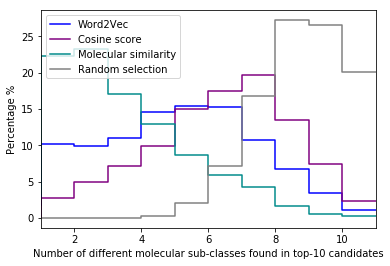

In [262]:
plt.step(np.arange(1,num_links+2), hist_w2v[:], 'blue', label='Word2Vec')
plt.step(np.arange(1,num_links+2), hist_cosine[:], 'purple', label='Cosine score')
plt.step(np.arange(1,num_links+2), hist_tanimoto[:], 'darkcyan', label='Molecular similarity')
plt.step(np.arange(1,num_links+2), hist_random[:], 'grey', label='Random selection')
plt.legend()
plt.xlabel('Number of different molecular sub-classes found in top-10 candidates')
plt.ylabel('Percentage %')
plt.xlim(1,num_links+1)
plt.savefig('comparison_mol_subclass.pdf')

In [264]:
test = np.where((M_sim_ctr - cosine_sim > 0.4) & (M_sim_ctr > 0.85) & (M_sim_ctr < 0.98) & (tanimoto_similarities > 0.8))

2549 1079
0.9055333861129978 0.44709918682958794 1.0
  Created documents for  2  of  2  spectra.

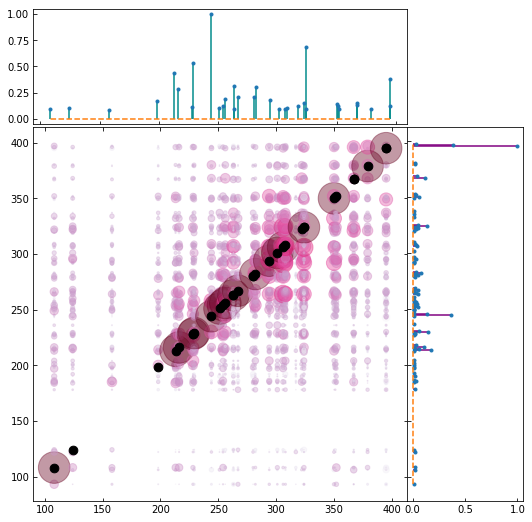

In [265]:
id = 94
ID1, ID2 = test[0][id], test[1][id]
print(ID1, ID2)
print(M_sim_ctr[ID1, ID2], cosine_sim[ID1, ID2], tanimoto_similarities[ID1, ID2])
Cdist_words = MS_functions.plot_spectra_comparison(MS_measure,
                                                   spectra,
                                                   2,
                                                  ID1, ID2, #283,1309, #50, 8878,
                                                 min_mz = 0, 
                                                 max_mz = 1000,
                                                 threshold = 0.01)

## GloVe

In [11]:
file_model_glove = PATH_SAVE_MODEL + 'model_glove_MS_uniquesmiles_d300_w300_iter10_loss500_minpeak10_dec2.model'
MS_measure.build_model_glove(file_model_glove, vector_size=300, window=300, 
                             learning_rate=0.05, workers=8, epochs=10, 
                             use_stored_model=True)

Load stored GloVe model ...


In [12]:
# Use peak intensities as extra weights
MS_measure.get_vectors_glove(extra_weights = MS_documents_intensity, tfidf_weighted=True)
MS_measure.get_glove_similarity(num_hits=25, method='cosine')

  Calculated GloVe vectors for  9550  of  9550  documents.Calculated GloVe vectors for  620  of  9550  documents. documents. Calculated GloVe vectors for  1990  of  9550  documents. 2070  of  9550  documents.2230  of  9550  documents.2790  of  9550  documents. Calculated GloVe vectors for  3940  of  9550  documents. of  9550  documents. Calculated GloVe vectors for  7120  of  9550  documents. Calculated GloVe vectors for  8490  of  9550  documents. Calculated GloVe vectors for  8680  of  9550  documents. 9090  of  9550  documents.Calculated distances between  9550  documents.


In [14]:
from scipy import spatial
M_sim = 1 - spatial.distance.cdist(MS_measure.vectors_glove, MS_measure.vectors_glove, 'cosine')

Set similarity threshold to:  0.9713280472075719


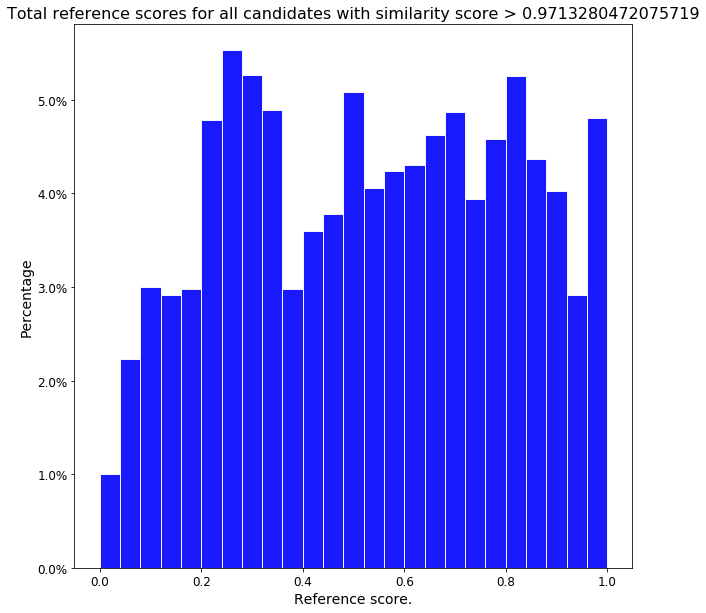

Percentage of highly similar molecules within selection:  57.06 %


In [15]:
num_best = 10000
threshold = np.sort(M_sim.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_glove.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

In [17]:
# Compare to case without using intensities as extra weights
MS_measure.get_vectors_glove(extra_weights = None, tfidf_weighted=True)
MS_measure.get_glove_similarity(num_hits=25, method='cosine')

  Calculated GloVe vectors for  9550  of  9550  documents.  of  9550  documents.Calculated distances between  9550  documents.


In [18]:
from scipy import spatial
M_sim = 1 - spatial.distance.cdist(MS_measure.vectors_glove, MS_measure.vectors_glove, 'cosine')

Set similarity threshold to:  0.9709511323748968


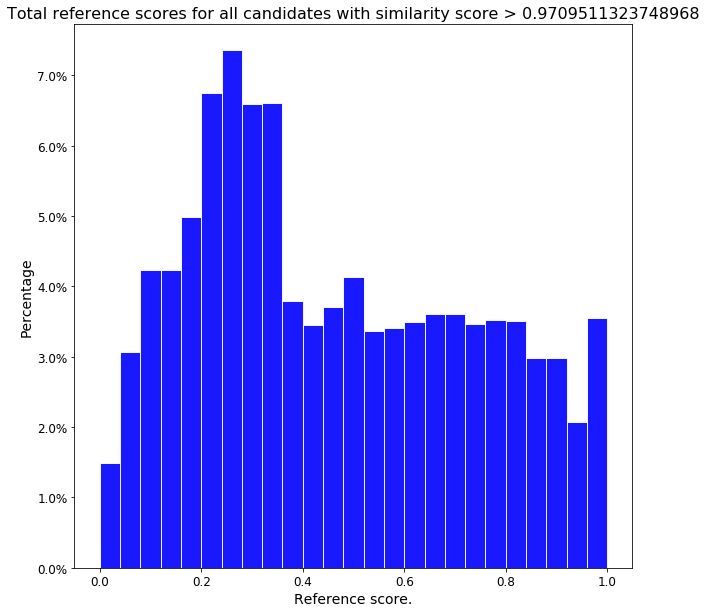

Percentage of highly similar molecules within selection:  43.72 %


In [19]:
num_best = 10000
threshold = np.sort(M_sim.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_glove2.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")